## Constants and dataloading

In [255]:
import json
import smart_open
import pandas as pd
import os
from tqdm import tqdm

FIGURE_DIR = "/Users/ianm/projects/ppl-suite-paper-runs/figures"
TABLES_DIR = "/Users/ianm/projects/ppl-suite-paper-runs/tables"
RESULTS_DIR = "/Users/ianm/projects/ppl-suite-paper-runs/results"
TOKEN_COUNTS_DIR = "/Users/ianm/projects/ppl-suite-paper-runs/token_counts"

metric_name = 'ppl_token'

model_name_to_path = {
    'dolma-1b': 'olmo/1b/olmo-small-dolma-150B-mcli-results-eos-fix/',
    'pile-1b': 'olmo/1b/olmo-small--pile-lumi-150B-mcli-results-eos-fix/',
    'falcon-1b': 'olmo/1b/olmo-small-falcon-150B-mcli-results-really-really-fixed-eos-full/',
    'rpj-1b': 'olmo/1b/olmo-small-rpj-lumi-150B-mcli-results-eos-fix/',
    # 'dolma-7b': 'olmo/7b/v1_5-mix-mitch-ish-1_5T_tokens',
    'pythia-160m': 'pythia/160m-seed1/',
    # 'pythia-160m-seed2': 'pythia/160m-seed2/',
    'pythia-1b': 'pythia/1b',
    'pythia-6.9b': 'pythia/7b',
    # 'rp-incite-7b': 'redpajama-incite/7b',
    
}

trained_baseline_models = {'dolma-1b', 'falcon-1b', 'pile-1b', 'rpj-1b'}

name_to_display = {
    'ppl_c4_en': 'C4',
    'ppl_falcon-refinedweb': 'Falcon',
    'ppl_mc4': 'MC4',
    'ppl_ptb': 'PTB',
    'ppl_wikitext_103': 'WikiText-103',
    'ppl_redpajama': 'RedPajama',
    'ppl_dolma-v1_5': 'Dolma V1.5',
    'ppl_pile': 'The Pile',
    'ppl_c4_100_domains': 'C4 100 Domains',
    'ppl_dolma_100_programing_languages': '100 PLs',
    'ppl_dolma_100_subreddits': '100 Subreddits',
    'ppl_ice_fixed': 'ICE',
    'ppl_m2d2_s2orc_unsplit': 'M2D2 S2ORC',
    'ppl_m2d2_wikipedia_unsplit': 'M2D2 Wikipedia',
    'ppl_manosphere_meta_sep': 'Manosphere',
    'ppl_twitterAAE_HELM_fixed': 'Twitter AAE',
    'ppl_4chan_meta_sep': '4chan',
    'ppl_gab': 'Gab',
    'model': 'Model',
    'model_size': 'Model Size',
    'split': 'Split',
    'tokens_seen': 'Tokens Seen',
    'training_dataset': 'Training Dataset',
    'training_steps': 'Training Steps',
    'bits_per_byte': 'Bits Per Byte',
    'ppl_token': 'Perplexity per Token',
    'All': 'All',
    'EAST_AFRICA_W_ALL': 'East Africa Written',
    'PHILIPPINES_S_ALL': 'Philippines Spoken',
    'PHILIPPINES_W_ALL': 'Philippines Written',
    'HONG_KONG_S_ALL': 'Hong Kong Spoken',
    'SINGAPORE_W_ALL': 'Singapore Written',
    'IRELAND_W_ALL': 'Ireland Written',
    'JAMAICA_S_ALL': 'Jamaica Spoken',
    'INDIA_S_ALL': 'India Spoken',
    'EAST_AFRICA_S_ALL': 'East Africa Spoken',
    'CANADA_S_ALL': 'Canada Spoken',
    'SINGAPORE_S_ALL': 'Singapore Spoken',
    'JAMAICA_W_ALL': 'Jamaica Written',
    'IRELAND_S_ALL': 'Ireland Spoken',
    'CANADA_W_ALL': 'Canada Written',
    'USA_W_ALL': 'USA Written',
    'INDIA_W_ALL': 'India Written',
    'HONG_KONG_W_ALL': 'Hong Kong Written',
    'AA': 'AA',
    'white': 'White',
    'pythia-6.9b': 'Pythia 7B',
    'pythia-1b': 'Pythia 1B',
    'pythia-160m': 'Pythia 160M',
    'pythia-160m-seed2': 'Pythia 160M Seed 2',
    'dolma-1b': 'Dolma v1.5 1B',
    'dolma-7b': 'Dolma 7B',
    'falcon-1b': 'Falcon-RefinedWeb 1B',
    'rpj-1b': 'RedPajama 1B',
    'rp-incite-7b': 'RedPajama 7B',
    'pile-1b': 'The Pile 1B',
    '1-Pythia 7B/Pythia 1B': '1-Pythia 7B/Pythia 1B',
    '1-Pythia 1B/Pythia 160M': '1-Pythia 1B/Pythia 160m'
}

name_to_macro = {
    'wikitext_103': '\\wikitext',
    'twitterAAE_HELM_fixed': '\\twitterAAE',
    'redpajama': '\\redPajama',
    'ptb': '\\ptb',
    'pile': '\\pile',
    'mc4': '\\mCFourEn',
    'manosphere_meta_sep': '\\manosphere',
    'm2d2_wikipedia_unsplit': '\\mTwoDTwoWiki',
    'm2d2_s2orc_unsplit': '\\mTwoDTwoSTwoORC',
    'ice_fixed': '\\ice',
    'gab': '\\gab',
    'falcon-refinedweb': '\\falcon',
    'dolma_100_subreddits': '\\dolmaOneHundredSubreddits',
    'dolma_100_programing_languages': '\\stackOneHundredLanguages',
    'dolma-v1_5': '\\dolma',
    'c4_en': '\\cFour',
    'c4_100_domains': '\\cFourOneHundredDomains',
    '4chan_meta_sep': '\\fourChan',
}

domain_order = [
    'c4_en',
    'mc4',
    'pile',
    'wikitext_103',
    'ptb',
    'redpajama',
    'falcon-refinedweb',
    'dolma-v1_5',
    
    'm2d2_s2orc_unsplit',
    'm2d2_wikipedia_unsplit',
    'c4_100_domains',
    'dolma_100_subreddits',
    'dolma_100_programing_languages',
    
    'ice_fixed',
    'twitterAAE_HELM_fixed',
    
    'manosphere_meta_sep',
    'gab',
    '4chan_meta_sep',
]

# {k: v for k, v in zip(model_dataset_names, ['o', 's', '^', 'x'])}
model_dataset_names_to_marker = {'Falcon-RefinedWeb olmo 1B': 'o',
 'RedPajama olmo 1B': '+',
 'Dolma V1.5 olmo 1B': '^',
 'The Pile olmo 1B': 'x'
 }

model_name_to_marker = {
    'dolma-1b': '^',
    'pile-1b': 'x',
    'falcon-1b': 'o',
    'rpj-1b': '+',
}

shared_cols = {
    'model',
    'model_size',
    'split',
    'tokens_seen',
    'training_dataset',
    'training_steps'
 }

non_domain_cols = {
    "date",
    "model",
    "model_kwargs",
    "full_model",
    "task",
    "processing_time",
    "num_instances",
    "tango_workspace",
    "tango_step",
    "model_max_length",
    "max_batch_tokens",
    "batch_size",
    "limit",
    "split",
    "random_subsample_seed",
    "model_size",
    "training_steps",
    "tokens_seen",
    "training_dataset"
}

fringe_domains = {
    'ppl_manosphere_meta_sep',
    'ppl_4chan_meta_sep',
    'ppl_gab'
}

standard_lm_benchmarks = {
    'ppl_c4_en',
    'ppl_falcon-refinedweb',
    'ppl_mc4',
    'ppl_ptb',
    'ppl_wikitext_103'
}

tasks_and_subdomain_reweighting = {
    # 'ppl_dolma-v1_5': { # from perplexity-eval/wimbd_stats_per_subdomain.sh on dolma-v1_5
    #     "books": 5151989406 / 3092471692994, "ppl_c4_en": 174063495691/ 3092471692994, "common-crawl": (682871579682 + 801847275633 + 929094243502) / 3092471692994, "pes2o": 57171277321/ 3092471692994, "reddit_uniform": 79691540960/ 3092471692994, "stack_uniform": 358898022843/3092471692994, "wiki": 3682267956/3092471692994
    #     },
    # 'ppl_dolma-v1_5': { # from perplexity-eval/wimbd_stats_per_subdomain.sh on dolma-v1_5 with cc sampled
    #     "books": 5151989406 / 1910952404219, 
    #     "ppl_c4_en": 174063495691/ 1910952404219, 
    #     "common-crawl": (348617970889 + 409351522960 + 474324316193) / 1910952404219, 
    #     "pes2o": 57171277321/ 1910952404219, 
    #     "reddit_uniform": 79691540960/ 1910952404219, 
    #     "stack_uniform": 358898022843/1910952404219,  # NOT decontaminated so we don't include it
    #     "wiki": 3682267956/1910952404219
    #     },
    'ppl_dolma-v1_5': { # from perplexity-eval/wimbd_stats_per_subdomain.sh on dolma-v1_5 with cc sampled and not including stack because it's not decontaminated
        "books": 5151989406 / 1552054381376, 
        "ppl_c4_en": 174063495691/ 1552054381376, 
        "common-crawl": (348617970889 + 409351522960 + 474324316193) / 1552054381376, 
        "pes2o": 57171277321/ 1552054381376, 
        "reddit_uniform": 79691540960/ 1552054381376, 
        "wiki": 3682267956/1552054381376
        },

        
    
    'ppl_pile': { # from perplexity-eval/wimbd_stats_per_subdomain.sh
                    'ArXiv': 0.1021663383292594,
                    'BookCorpus2': 0.006922684974746704,
                    'Books3': 0.11430444331955997,
                    'DM_Mathematics': 0.021418015498677917,
                    'Enron_Emails': 0.001426531147330422,
                    'EuroParl': 0.008709394330168848,
                    'FreeLaw': 0.055446124418841794,
                    'Github': 0.09815765131220212,
                    'Gutenberg_PG-19': 0.020758335180918297,
                    'HackerNews': 0.006169988959995758,
                    'NIH_ExPorter': 0.0021734138919789394,
                    'OpenSubtitles': 0.016527839624960433,
                    'OpenWebText2': 0.09001673683420781,
                    'PhilPapers': 0.00367360871649158,
                    'Pile-CC': 0.1602808622426978,
                    'PubMed_Abstracts': 0.024288423952683613,
                    'PubMed_Central': 0.12685529942277587,
                    'StackExchange': 0.055784225862886144,
                    'USPTO_Backgrounds': 0.028646698997411003,
                    'Ubuntu_IRC': 0.011659962869647829,
                    'Wikipedia_en': 0.03656375466905958,
                    'YoutubeSubtitles': 0.008049665443498185
                },
    # 'ppl_redpajama': {'arxiv': 28 / 1210, 'books': 26 / 1210, 'c4': 175 / 1210, 'commoncrawl': 878 / 1210, 'github': 59 / 1210, 'stackexchange': 20 / 1210, 'wikipedia': 24 / 1210}
    'ppl_redpajama': {"arxiv": 28068980377 / 1209573710724, "books": 25998961820 / 1209573710724, "c4": 174234183378 / 1209573710724, "commoncrawl": 877147320219 / 1209573710724, "github": 58844752403 / 1209573710724, "stackexchange": 20494412414 / 1209573710724, "wikipedia": 24785100113 / 1209573710724}
}

def display_size(size, use_non_embedding_params=False):
    if size == 85056000: # pythia 160m
        return "160M"
    elif size == 805736448: # pythia 1b
        return "1B"
    elif size == 1177240704: # dolma 1b and our baselines
        return "1B"
    elif size == 6444163072: # pythia 6.9b
        return "7B"
    elif size == 6855589888: # rp-incite 7b
        return "7B"
    elif use_non_embedding_params:
        if size < 1000000000:
            return f"{math.ceil(size/1000000)}M"
        else:
            return f"{math.ceil(size/1000000000)}B"
    else:
        raise ValueError(f"Unknown size: {size}")

def human_readable_int(num, precision=0):
    if num < 1000:
        return f"{num:.{precision}f}"
    elif num < 1000000:
        return f"{num/1000:.{precision}f}K"
    elif num < 1000000000:
        return f"{num/1000000:.{precision}f}M"
    else:
        return f"{num/1000000000:.{precision}f}B"

def standardize_model_metadata(row):
    if row['model'].startswith('s3://ai2-llm/checkpoints/1b/olmo-small-dolma-150B-mcli'):
        # if 'limit' in row:
        #     assert row['limit'] is None
        #     del row['limit']
        # if 'model_kwargs' in row:
        #     assert row['model_kwargs'] == {'revision': None, 'trust_remote_code': True}
        #     del row['model_kwargs']
        # if 'full_model' in row:
        #     del row['full_model']
        # if 'random_subsample_seed' in row:
        #     del row['random_subsample_seed']
        # if 'tango_step' in row:
        #     del row['tango_step']
        # if 'tango_workspace' in row:
        #     del row['tango_workspace']
        # if 'model_max_length' in row:
        #     assert row['model_max_length'] == 2048
        #     del row['model_max_length']
        # if 'max_batch_tokens' in row:
        #     del row['max_batch_tokens']
        # if 'batch_size' in row:
        #     del row['batch_size']
        # if 'processing_time' in row:
        #     del row['processing_time']
        # original_model_name = row['model']
        # row['original_model_name'] = original_model_name
        # row['model'] = 'olmo'
        # row['model_size'] = 1177240704 # provided by Ananya non embedding params
        # row['training_steps'] = int(original_model_name.split('/')[-1].split('-')[0].replace('step', ''))
        # row['tokens_seen'] = row['training_steps'] * 4325376 # max_sequence_length: 2048 * global_train_batch_size: 2112 = 4,325,376
        # row['training_dataset'] = 'Dolma V1.5'
        # revision in model name version 
        if 'limit' in row:
            assert row['limit'] is None
            del row['limit']
        if 'full_model' in row:
            del row['full_model']
        if 'random_subsample_seed' in row:
            del row['random_subsample_seed']
        if 'tango_step' in row:
            del row['tango_step']
        if 'tango_workspace' in row:
            del row['tango_workspace']
        if 'model_max_length' in row:
            assert row['model_max_length'] == 2048
            del row['model_max_length']
        if 'max_batch_tokens' in row:
            del row['max_batch_tokens']
        if 'batch_size' in row:
            del row['batch_size']
        if 'processing_time' in row:
            del row['processing_time']
        original_model_name = row['model']
        # row['original_model_name'] = original_model_name
        row['model'] = 'olmo'
        row['model_size'] = 1177240704 # provided by Ananya non embedding params
        row['training_steps'] = int(row['model_kwargs']['revision'].split('-')[0].replace('step', '') if 'model_kwargs' in row else row['revision'].split('-')[0].replace('step', ''))
        row['tokens_seen'] = row['training_steps'] * 4325376 # max_sequence_length: 2048 * global_train_batch_size: 2112 = 4,325,376
        row['training_dataset'] = 'Dolma V1.5'
        if 'model_kwargs' in row:
            # assert row['model_kwargs'] == {'revision': , 'trust_remote_code': True}
            del row['model_kwargs']
        if 'revision' in row:
            del row['revision']
    elif row['model'].startswith('s3://ai2-llm/checkpoints/1b/olmo-small-falcon-150B-mcli-hf-tokenizer'):
        # if 'limit' in row:
        #     assert row['limit'] is None
        #     del row['limit']
        # if 'model_kwargs' in row:
        #     assert row['model_kwargs'] == {'revision': None, 'trust_remote_code': True}
        #     del row['model_kwargs']
        # if 'full_model' in row:
        #     del row['full_model']
        # if 'random_subsample_seed' in row:
        #     del row['random_subsample_seed']
        # if 'tango_step' in row:
        #     del row['tango_step']
        # if 'tango_workspace' in row:
        #     del row['tango_workspace']
        # if 'model_max_length' in row:
        #     assert row['model_max_length'] == 2048
        #     del row['model_max_length']
        # if 'max_batch_tokens' in row:
        #     del row['max_batch_tokens']
        # if 'batch_size' in row:
        #     del row['batch_size']
        # if 'processing_time' in row:
        #     del row['processing_time']
        # original_model_name = row['model']
        # # row['original_model_name'] = original_model_name
        # row['model'] = 'olmo'
        # row['model_size'] = 1177240704 # provided by Ananya non embedding params
        # row['training_steps'] = int(original_model_name.split('/')[-1].split('-')[0].replace('step', ''))
        # row['tokens_seen'] = row['training_steps'] * 4325376 # max_sequence_length: 2048 * global_train_batch_size: 2112 = 4,325,376
        # row['training_dataset'] = 'Falcon-RefinedWeb'
        # revision in model name version 
        if 'limit' in row:
            assert row['limit'] is None
            del row['limit']
        if 'full_model' in row:
            del row['full_model']
        if 'random_subsample_seed' in row:
            del row['random_subsample_seed']
        if 'tango_step' in row:
            del row['tango_step']
        if 'tango_workspace' in row:
            del row['tango_workspace']
        if 'model_max_length' in row:
            assert row['model_max_length'] == 2048
            del row['model_max_length']
        if 'max_batch_tokens' in row:
            del row['max_batch_tokens']
        if 'batch_size' in row:
            del row['batch_size']
        if 'processing_time' in row:
            del row['processing_time']
        original_model_name = row['model']
        # row['original_model_name'] = original_model_name
        row['model'] = 'olmo'
        row['model_size'] = 1177240704 # provided by Ananya non embedding params
        row['training_steps'] = int(row['model_kwargs']['revision'].split('-')[0].replace('step', '') if 'model_kwargs' in row else row['revision'].split('-')[0].replace('step', ''))
        row['tokens_seen'] = row['training_steps'] * 4325376 # max_sequence_length: 2048 * global_train_batch_size: 2112 = 4,325,376
        row['training_dataset'] = 'Falcon-RefinedWeb'
        if 'model_kwargs' in row:
            # assert row['model_kwargs'] == {'revision': , 'trust_remote_code': True}
            del row['model_kwargs']
        if 'revision' in row:
            del row['revision']
    elif row['model'].startswith('s3://ai2-llm/checkpoints/1b/olmo-small-rpj-lumi-150B-mcli-hf-tokenizer'):
        if 'limit' in row:
            assert row['limit'] is None
            del row['limit']
        if 'full_model' in row:
            del row['full_model']
        if 'random_subsample_seed' in row:
            del row['random_subsample_seed']
        if 'tango_step' in row:
            del row['tango_step']
        if 'tango_workspace' in row:
            del row['tango_workspace']
        if 'model_max_length' in row:
            assert row['model_max_length'] == 2048
            del row['model_max_length']
        if 'max_batch_tokens' in row:
            del row['max_batch_tokens']
        if 'batch_size' in row:
            del row['batch_size']
        if 'processing_time' in row:
            del row['processing_time']
        original_model_name = row['model']
        # row['original_model_name'] = original_model_name
        row['model'] = 'olmo'
        row['model_size'] = 1177240704 # provided by Ananya non embedding params
        row['training_steps'] = int(row['model_kwargs']['revision'].split('-')[0].replace('step', '') if 'model_kwargs' in row else row['revision'].split('-')[0].replace('step', ''))
        row['tokens_seen'] = row['training_steps'] * 4325376 # max_sequence_length: 2048 * global_train_batch_size: 2112 = 4,325,376
        row['training_dataset'] = 'RedPajama'
        if 'model_kwargs' in row:
            # assert row['model_kwargs'] == {'revision': , 'trust_remote_code': True}
            del row['model_kwargs']
        if 'revision' in row:
            del row['revision']
    elif row['model'].startswith('s3://ai2-llm/checkpoints/1b/olmo-small-pile-lumi-150B-mcli-hf-tokenizer'):
        if 'limit' in row:
            assert row['limit'] is None
            del row['limit']
        if 'full_model' in row:
            del row['full_model']
        if 'random_subsample_seed' in row:
            del row['random_subsample_seed']
        if 'tango_step' in row:
            del row['tango_step']
        if 'tango_workspace' in row:
            del row['tango_workspace']
        if 'model_max_length' in row:
            assert row['model_max_length'] == 2048
            del row['model_max_length']
        if 'max_batch_tokens' in row:
            del row['max_batch_tokens']
        if 'batch_size' in row:
            del row['batch_size']
        if 'processing_time' in row:
            del row['processing_time']
        original_model_name = row['model']
        # row['original_model_name'] = original_model_name
        row['model'] = 'olmo'
        row['model_size'] = 1177240704 # provided by Ananya non embedding params
        row['training_steps'] = int(row['model_kwargs']['revision'].split('-')[0].replace('step', '') if 'model_kwargs' in row else row['revision'].split('-')[0].replace('step', ''))
        row['tokens_seen'] = row['training_steps'] * 4325376 # max_sequence_length: 2048 * global_train_batch_size: 2112 = 4,325,376
        row['training_dataset'] = 'The Pile'
        if 'model_kwargs' in row:
            # assert row['model_kwargs'] == {'revision': , 'trust_remote_code': True}
            del row['model_kwargs']
        if 'revision' in row:
            del row['revision']
    elif row['model'].startswith('EleutherAI/pythia-160m-seed1'):
        if 'limit' in row:
            assert row['limit'] is None
            del row['limit']
        if 'full_model' in row:
            del row['full_model']
        if 'random_subsample_seed' in row:
            del row['random_subsample_seed']
        if 'tango_step' in row:
            del row['tango_step']
        if 'tango_workspace' in row:
            del row['tango_workspace']
        if 'model_max_length' in row:
            assert row['model_max_length'] == 2048
            del row['model_max_length']
        if 'max_batch_tokens' in row:
            del row['max_batch_tokens']
        if 'batch_size' in row:
            del row['batch_size']
        if 'processing_time' in row:
            del row['processing_time']
        original_model_name = row['model']
        # row['original_model_name'] = original_model_name
        row['model'] = 'pythia'
        row['model_size'] = 85056000 # non-embedding params 
        if 'model_kwargs' in row:
            row['training_steps'] = int(row['model_kwargs']['revision'].replace('step', ''))
        else:
            row['training_steps'] = int(row['revision'].replace('step', ''))
        row['tokens_seen'] = row['training_steps'] * 2097152 # from paper
        row['training_dataset'] = 'The Pile'

        if 'model_kwargs' in row:
            # assert row['model_kwargs'] == {'revision': , 'trust_remote_code': True}
            del row['model_kwargs']
        if 'revision' in row:
            del row['revision']
    elif row['model'].startswith('EleutherAI/pythia-160m-seed2'):
        if 'limit' in row:
            assert row['limit'] is None
            del row['limit']
        if 'full_model' in row:
            del row['full_model']
        if 'random_subsample_seed' in row:
            del row['random_subsample_seed']
        if 'tango_step' in row:
            del row['tango_step']
        if 'tango_workspace' in row:
            del row['tango_workspace']
        if 'model_max_length' in row:
            assert row['model_max_length'] == 2048
            del row['model_max_length']
        if 'max_batch_tokens' in row:
            del row['max_batch_tokens']
        if 'batch_size' in row:
            del row['batch_size']
        if 'processing_time' in row:
            del row['processing_time']
        original_model_name = row['model']
        # row['original_model_name'] = original_model_name
        row['model'] = 'pythia'
        row['model_size'] = 85056000 # non-embedding params 
        if 'model_kwargs' in row:
            row['training_steps'] = int(row['model_kwargs']['revision'].replace('step', ''))
        else:
            row['training_steps'] = int(row['revision'].replace('step', ''))
        row['tokens_seen'] = row['training_steps'] * 2097152 # from paper
        row['training_dataset'] = 'The Pile'

        if 'model_kwargs' in row:
            # assert row['model_kwargs'] == {'revision': , 'trust_remote_code': True}
            del row['model_kwargs']
        if 'revision' in row:
            del row['revision']
    elif row['model'].startswith('EleutherAI/pythia-1b'):
        if 'limit' in row:
            assert row['limit'] is None
            del row['limit']
        if 'full_model' in row:
            del row['full_model']
        if 'random_subsample_seed' in row:
            del row['random_subsample_seed']
        if 'tango_step' in row:
            del row['tango_step']
        if 'tango_workspace' in row:
            del row['tango_workspace']
        if 'model_max_length' in row:
            assert row['model_max_length'] == 2048
            del row['model_max_length']
        if 'max_batch_tokens' in row:
            del row['max_batch_tokens']
        if 'batch_size' in row:
            del row['batch_size']
        if 'processing_time' in row:
            del row['processing_time']
        original_model_name = row['model']
        # row['original_model_name'] = original_model_name
        row['model'] = 'pythia'
        row['model_size'] = 805736448 # non-embedding params 
        if 'model_kwargs' in row:
            row['training_steps'] = int(row['model_kwargs']['revision'].replace('step', ''))
        else:
            row['training_steps'] = int(row['revision'].replace('step', ''))
        row['tokens_seen'] = row['training_steps'] * 2097152 # from paper
        row['training_dataset'] = 'The Pile'

        if 'model_kwargs' in row:
            # assert row['model_kwargs'] == {'revision': , 'trust_remote_code': True}
            del row['model_kwargs']
        if 'revision' in row:
            del row['revision']
    elif row['model'].startswith('EleutherAI/pythia-6.9b'):
        if 'limit' in row:
            assert row['limit'] is None
            del row['limit']
        if 'full_model' in row:
            del row['full_model']
        if 'random_subsample_seed' in row:
            del row['random_subsample_seed']
        if 'tango_step' in row:
            del row['tango_step']
        if 'tango_workspace' in row:
            del row['tango_workspace']
        if 'model_max_length' in row:
            assert row['model_max_length'] == 2048
            del row['model_max_length']
        if 'max_batch_tokens' in row:
            del row['max_batch_tokens']
        if 'batch_size' in row:
            del row['batch_size']
        if 'processing_time' in row:
            del row['processing_time']
        original_model_name = row['model']
        # row['original_model_name'] = original_model_name
        row['model'] = 'pythia'
        row['model_size'] = 6444163072 # non-embedding params 
        if 'model_kwargs' in row:
            row['training_steps'] = int(row['model_kwargs']['revision'].replace('step', ''))
        else:
            row['training_steps'] = int(row['revision'].replace('step', ''))
        row['tokens_seen'] = row['training_steps'] * 2097152 # from paper
        row['training_dataset'] = 'The Pile'

        if 'model_kwargs' in row:
            # assert row['model_kwargs'] == {'revision': , 'trust_remote_code': True}
            del row['model_kwargs']
        if 'revision' in row:
            del row['revision']
    elif row['model'] == ('togethercomputer/RedPajama-INCITE-7B-Base'):
        if 'limit' in row:
            assert row['limit'] is None
            del row['limit']
        if 'full_model' in row:
            del row['full_model']
        if 'random_subsample_seed' in row:
            del row['random_subsample_seed']
        if 'tango_step' in row:
            del row['tango_step']
        if 'tango_workspace' in row:
            del row['tango_workspace']
        if 'model_max_length' in row:
            assert row['model_max_length'] == 2048
            del row['model_max_length']
        if 'max_batch_tokens' in row:
            del row['max_batch_tokens']
        if 'batch_size' in row:
            del row['batch_size']
        if 'processing_time' in row:
            del row['processing_time']
        original_model_name = row['model']
        # row['original_model_name'] = original_model_name
        row['model'] = 'rp-incite'
        row['model_size'] = 6855589888 # non-embedding params from sum([p.numel() for p in model.parameters() if p.dim() > 1])
        if 'model_kwargs' in row:
            row['tokens_seen'] = 1000000000000 if row['model_kwargs']['revision'] == '1t_tokens' else int(row['model_kwargs']['revision'].split('b')[0]) * 1000000000
        else:
            row['tokens_seen'] = 1000000000000 if row['revision'] == '1t_tokens' else int(row['revision'].split('b')[0]) * 1000000000
        row['training_steps'] = int(row['tokens_seen'] / 4000000) # from hf website "Gradient Accumulations: 8 (global batch size 4M tokens)"
        row['training_dataset'] = 'RedPajama'

        if 'model_kwargs' in row:
            # assert row['model_kwargs'] == {'revision': , 'trust_remote_code': True}
            del row['model_kwargs']
        if 'revision' in row:
            del row['revision']
    elif row['model'].startswith('s3://ai2-llm/checkpoints/7b/v1_5-mix-mitch-ish-hf-tokenizer-olmo/'):
        if 'limit' in row:
            assert row['limit'] is None
            del row['limit']
        if 'model_kwargs' in row:
            assert row['model_kwargs'] == {'revision': None, 'trust_remote_code': True}
            del row['model_kwargs']
        if 'full_model' in row:
            del row['full_model']
        if 'random_subsample_seed' in row:
            del row['random_subsample_seed']
        if 'tango_step' in row:
            del row['tango_step']
        if 'tango_workspace' in row:
            del row['tango_workspace']
        if 'model_max_length' in row:
            assert row['model_max_length'] == 2048
            del row['model_max_length']
        if 'max_batch_tokens' in row:
            del row['max_batch_tokens']
        if 'batch_size' in row:
            del row['batch_size']
        if 'processing_time' in row:
            del row['processing_time']
        original_model_name = row['model']
        # row['original_model_name'] = original_model_name
        row['model'] = 'olmo'
        row['model_size'] = 7000000000 # todo get exact value
        row['training_steps'] = int(original_model_name.split('/')[-1].split('-')[0].replace('step', ''))
        row['tokens_seen'] = row['training_steps'] * 4423680 # TODO CONFIRM max_sequence_length: 2048 * global_train_batch_size: 2160 = 4,423,680
        row['training_dataset'] = 'Dolma V1.5'
    else:
        # pass
        raise ValueError(f"Unknown model: {row['model']}")
    return row

def read_jsonl(path, apply_standardization=True, verbose=False):
    with smart_open.open(path, 'rt') as fin:
        for line in tqdm(fin, desc=f"Reading {path}", disable=not verbose):
            data = json.loads(line)
            data = standardize_model_metadata(data) if apply_standardization else data
            yield data

all_standard_tasks = list(standard_lm_benchmarks) + list(tasks_and_subdomain_reweighting.keys())

domains_with_subdomains = set()
for sheet_name in os.listdir(os.path.join(RESULTS_DIR, model_name_to_path['dolma-1b'])):
    if sheet_name.endswith("subdomains.jsonl.gz") and not sheet_name.startswith("bits_per_byte"):
        domains_with_subdomains.add("_".join(sheet_name.split("_")[2:-1]))

domains_without_subdomains = set(pd.DataFrame(read_jsonl(os.path.join(os.path.join(RESULTS_DIR, model_name_to_path['dolma-1b']), "ppl_metrics.jsonl.gz")))['task']) - domains_with_subdomains
domains_without_subdomains_clean = set(d for d in domains_without_subdomains if all(fringe_domain not in d for fringe_domain in fringe_domains))
domains_with_subdomains_clean = set(domains_with_subdomains) - fringe_domains
all_domains = domains_with_subdomains | domains_without_subdomains

results_files_all = os.listdir(os.path.join(RESULTS_DIR, model_name_to_path['dolma-1b']))
results_files_clean = [f for f in results_files_all if all(fringe_domain not in f for fringe_domain in fringe_domains)]

# map from task to domain
task_to_domains = {}
for task in domains_with_subdomains:
    data = read_jsonl(os.path.join(os.path.join(RESULTS_DIR, model_name_to_path['dolma-1b']), f"ppl_token_{task}_subdomains.jsonl.gz"))
    domains = set(next(data).keys()) - non_domain_cols
    # print(domains)
    # print(len(domains))
    task_to_domains[task] = set(next(data).keys()) - non_domain_cols

tasts_to_domains_clean = { task: task_to_domains[task] for task in domains_with_subdomains_clean }
domains_to_tasks = { domain: task for task in task_to_domains for domain in task_to_domains[task] }

In [204]:

# ppl_redpajama_token_count_avg_logits = pd.DataFrame(read_jsonl(os.path.join(os.path.join(RESULTS_DIR, model_name_to_path['falcon-1b']), "ppl_ice_fixed_token_count_avg_logits.jsonl.gz")))
# ppl_redpajama_token_count_avg_logits.head()
# ppl_token_ppl_twitterAAE_HELM_fixed_subdomains = pd.DataFrame(read_jsonl(os.path.join(os.path.join(RESULTS_DIR, model_name_to_path['falcon-1b']), "ppl_token_ppl_pile_subdomains.jsonl.gz")))
# ppl_token_ppl_twitterAAE_HELM_fixed_subdomains.T
ppl_token_ppl_twitterAAE_HELM_fixed_subdomains = pd.DataFrame(read_jsonl(os.path.join(os.path.join(RESULTS_DIR, model_name_to_path['falcon-1b']), "ppl_token_ppl_dolma-v1_5_subdomains.jsonl.gz")))
ppl_token_ppl_twitterAAE_HELM_fixed_subdomains.T
# ppl_metrics = pd.DataFrame(read_jsonl(os.path.join(os.path.join(RESULTS_DIR, model_name_to_path['falcon-1b']), "ppl_metrics.jsonl.gz")))
# ppl_metrics[ppl_metrics['tokens_seen'] == 43253760000]
# ppl_token_ppl_twitterAAE_HELM_fixed_subdomains = pd.DataFrame(read_jsonl(os.path.join(os.path.join(RESULTS_DIR, model_name_to_path['pythia-6.9b']), "ppl_token_ppl_twitterAAE_HELM_fixed_subdomains.jsonl.gz")))
# ppl_token_ppl_twitterAAE_HELM_fixed_subdomains

,0,1,2,3,4,5,6
date,2023-11-25 07:26:13 UTC,2023-11-25 07:26:14 UTC,2023-11-25 07:26:14 UTC,2023-11-25 07:26:14 UTC,2023-11-25 07:26:14 UTC,2023-11-25 07:26:14 UTC,2023-11-25 07:26:14 UTC
model,olmo,olmo,olmo,olmo,olmo,olmo,olmo
task,ppl_dolma-v1_5,ppl_dolma-v1_5,ppl_dolma-v1_5,ppl_dolma-v1_5,ppl_dolma-v1_5,ppl_dolma-v1_5,ppl_dolma-v1_5
num_instances,4490,4490,4490,4490,4490,4490,4490
reddit_uniform,32.403122,27.939895,26.978751,25.874665,25.591298,24.805769,24.4714
common-crawl,21.693018,18.725809,17.953803,17.312835,16.882583,16.600726,16.29884
pes2o,17.541134,14.705287,13.970141,13.466364,13.153543,12.857058,12.627077
wiki,17.460468,14.883164,14.198231,13.622279,13.255077,12.995503,12.777681
stack_uniform,61.603602,47.433348,27.103403,21.436108,33.880395,21.135906,19.470546
books,22.84176,18.856977,18.223263,16.404497,16.040041,15.763335,15.447079


## Common Funcs

In [3]:
from functools import reduce
import numpy as np
import math

def make_subdomain_of_task(model_path, task_names, metric_name):
    ppl_metrics = pd.DataFrame(read_jsonl(os.path.join(model_path, "ppl_metrics.jsonl.gz")))
    dfs = []
    assert set(task_names) <= set(ppl_metrics['task'])
    for task_name in task_names:
        task_df = ppl_metrics[ppl_metrics['task'] == task_name]
        new_df = task_df[list(shared_cols)].copy()
        new_df[task_name] = task_df[metric_name]
        dfs.append(new_df)
    
    return dfs

def get_metric_for_all_subdomains(model_path, sheet_names, metric_name, include_non_subdomain_tasks=None, provided_dfs=None):
    dfs = [] if provided_dfs is None else provided_dfs
    if include_non_subdomain_tasks:
        dfs.extend(make_subdomain_of_task(model_path, include_non_subdomain_tasks, metric_name))
    for k in sheet_names:
        if not k.endswith('subdomains.jsonl.gz'):
            continue
        if k.startswith(metric_name):
            df = pd.DataFrame(read_jsonl(os.path.join(model_path, k)))
            
            df = df[list(df.columns.difference(non_domain_cols - shared_cols))]
            dfs.append(df)
    if len(dfs) == 0:
        raise ValueError(f"No dataframes found for {model_path} {sheet_names} {metric_name}")
    
    # join all the dfs on the domain cols, by concatenating the domain cols
    merged_df = reduce(lambda left,right: pd.merge(left,right,on=list(shared_cols), how='outer'), dfs)
    return merged_df

def get_metric_weighted_by_subdomains(all_subdomains_df, subdomain_weights, task_name, bits_per_byte=False):
    domain_cols = list(set(all_subdomains_df.columns) - shared_cols)
    new_df = all_subdomains_df[list(shared_cols)].copy()
    # subdomain_weights = {col_name: weight} so apply this to respective columns
    for col_name, weight in subdomain_weights.items():
        if bits_per_byte:
            all_subdomains_df[col_name] = all_subdomains_df[col_name] * weight
        else:
            all_subdomains_df[col_name] = np.log(all_subdomains_df[col_name]) * weight
            all_subdomains_df[col_name] = np.exp(all_subdomains_df[col_name])
    new_df[task_name] = all_subdomains_df[domain_cols].sum(axis=1)

    return new_df

def get_avg_over_all_subdomains(df):
    domain_cols = list(set(df.columns) - shared_cols)
    new_df = df[list(shared_cols)].copy()
    new_df['avg_over_subdomains'] = df[domain_cols].mean(axis=1)
    return new_df

def get_median_over_all_subdomains(df):
    domain_cols = list(set(df.columns) - shared_cols)
    new_df = df[list(shared_cols)].copy()
    new_df['median_over_subdomains'] = df[domain_cols].median(axis=1)
    return new_df

def get_win_rate_over_all_subdomains(df):
    domain_cols = list(set(df.columns) - shared_cols)
    new_df = df[list(shared_cols)].copy()
    new_df['win_rate_over_subdomains'] = df.apply(lambda row: sum(row[domain_cols] == df[domain_cols].min()), axis=1) / len(domain_cols)
    return new_df

def get_win_rate_over_all_subdomains_by_nearest(df, nearest_measure, max_distance):
    domain_cols = list(set(df.columns) - shared_cols)
    # sort df by nearest measure
    df = df.sort_values(by=[nearest_measure])
    # iterate over each row
    new_df = []
    row_buffer = []
    for i, row in df.iterrows():
        if len(row_buffer) == 0:
            row_buffer.append(row)
            continue
        elif row['model'] != row_buffer[0]['model'] and row['model_size'] != row_buffer[0]['model_size']:
            row_buffer.append(row)
            continue
        else:
            row_df = pd.DataFrame(row_buffer)
            if (row_df[nearest_measure].max() - row_df[nearest_measure].min() > max_distance):
                print(row_df[list(shared_cols)])
            if len(row_buffer) >1 and (row_df[nearest_measure].max() - row_df[nearest_measure].min() <= max_distance):
                assert len(row_df) == len(set(row_df[['model','model_size']]))
                row_df[f'win_rate_with_nearest'] = row_df.apply(lambda row: sum(row[domain_cols] == row_df[domain_cols].min()), axis=1) / len(domain_cols)
                new_df.append(row_df)
            row_buffer = []
            row_buffer.append(row)
    
    new_df = pd.concat(new_df)
    return new_df


def get_metric_for_all_subdomains_from_vocab(model_path, task_names, metric_name, vocab, task_granularity=False):
    files = [task+'_token_count_avg_logits.jsonl.gz' for task in task_names]
    dfs = []
    for task_name, file in zip(task_names,files):
        token_counts = pd.DataFrame(read_jsonl(os.path.join(model_path, file)))
        if 'split' in token_counts.columns:
            token_counts.drop(columns=['split'], inplace=True)
        token_counts = token_counts[token_counts['token'].isin(vocab)]
        rows = []
        for _, model_df in token_counts.groupby(['model', 'model_size', 'training_dataset', 'training_steps']):
            subdomain_metrics = {}
            if task_granularity:
                # truncate all subdomains to just the task
                model_df['subdomain'] = task_name
            for subdomain, subdomain_df in model_df.groupby('subdomain'):
                sum_logits = (subdomain_df['avg_logits'] * subdomain_df['count']).sum()
                if metric_name == 'ppl_token':
                    subdomain_metric = math.exp(-sum_logits / subdomain_df['count'].sum())
                else:
                    raise ValueError(f"Unknown metric name {metric_name}")
                subdomain = '__'.join(subdomain.split('__')[1:]) if len(subdomain.split('__')) > 1 else subdomain.split('__')[0]
                subdomain_metrics[subdomain] = subdomain_metric # 
            for col in shared_cols:
                if col not in model_df.columns:
                    continue
                subdomain_metrics[col] = model_df[col].iloc[0]
            rows.append(subdomain_metrics)        
        dfs.append(pd.DataFrame(rows))

    present_shared_cols = [col for col in shared_cols if all([col in df.columns for df in dfs])]
    merged_df = reduce(lambda left,right: pd.merge(left,right,on=list(present_shared_cols), how='outer'), dfs)
    return merged_df


    

## Exploration


In [4]:
# # get subdomains in a file
# all_subdomains_df = get_metric_for_all_subdomains(os.path.join(RESULTS_DIR, model_name_to_path['rp-incite-7b']), ['ppl_token_ppl_redpajama_subdomains.jsonl.gz'], "ppl", [])
# set(all_subdomains_df.columns)-shared_cols

## PMI tokens

In [5]:
# # get token counts over all ppl suite from one run
# token_count_results_files = [f for f in results_files_all if f.endswith("token_count_avg_logits.jsonl.gz")]

# def get_token_type_sum_nll(token_count_results_files, model_name, subdomain=None):
#     all_token_sum_nll = {}
#     for file in token_count_results_files:
#         token_counts = pd.DataFrame(read_jsonl(os.path.join(os.path.join(RESULTS_DIR, model_name_to_path[model_name]), file)))[['token', 'count','subdomain', 'avg_logits']]
#         for token, count, subdomain_field, avg_logits in tqdm(token_counts.values, desc=f"counting tokens in {file}"):
#             if subdomain is not None and subdomain != subdomain_field:
#                 continue
#             if token not in all_token_sum_nll:
#                 all_token_sum_nll[token] = 0
#             all_token_sum_nll[token] += count * avg_logits
#     return all_token_sum_nll

# all_token_sum_nll = get_token_type_sum_nll(token_count_results_files, 'falcon-1b')

# # with open(os.path.join(TOKEN_COUNTS_DIR, "full_suite_token_counts.json"), 'w') as fout:
# #     json.dump(all_token_counts, fout)
# # with open(os.path.join(TOKEN_COUNTS_DIR, "full_suite_token_counts.json"), 'r') as fin:
# #     all_token_counts = json.load(fin)

# all_token_sum_nll

In [6]:
# # sort tokens by sum nll
# sorted_tokens = sorted(all_token_sum_nll.items(), key=lambda item: item[1])
# sorted_tokens[:10]

In [7]:
# get token counts over all ppl suite from one run
token_count_results_files = [f for f in results_files_all if f.endswith("token_count_avg_logits.jsonl.gz")]

def get_token_counts(token_count_results_files, subdomain=None):
    all_token_counts = {}
    for file in token_count_results_files:
        token_counts = pd.DataFrame(read_jsonl(os.path.join(os.path.join(RESULTS_DIR, model_name_to_path['dolma-1b']), file)))[['token', 'count','subdomain']]
        for token, count, subdomain_field in tqdm(token_counts.values, desc=f"counting tokens in {file}"):
            if subdomain is not None and subdomain != subdomain_field:
                continue
            if token not in all_token_counts:
                all_token_counts[token] = 0
            all_token_counts[token] += count
    return all_token_counts

def get_token_freqs(token_counts):
    total_count = sum(token_counts.values())
    return {token: count / total_count for token, count in token_counts.items()}
# # all_token_counts = {}
# # for file in token_count_results_files:
# #     token_counts = pd.DataFrame(read_jsonl(os.path.join(os.path.join(RESULTS_DIR, model_name_to_path['dolma-1b']), file)))[['token', 'count']]
# #     for token, count in tqdm(token_counts.values, desc=f"counting tokens in {file}"):
# #         if token not in all_token_counts:
# #             all_token_counts[token] = 0
# #         all_token_counts[token] += count

# all_token_counts = get_token_counts(token_count_results_files)

# with open(os.path.join(TOKEN_COUNTS_DIR, "full_suite_token_counts.json"), 'w') as fout:
#     json.dump(all_token_counts, fout)
with open(os.path.join(TOKEN_COUNTS_DIR, "full_suite_token_counts.json"), 'r') as fin:
    all_token_counts = json.load(fin)

all_token_freqs = get_token_freqs(all_token_counts)
all_token_freqs

{' concedes': 2.244792929216544e-07,
 ' reacted': 2.5534519569838186e-06,
 ' gardens': 3.942417581936556e-06,
 ' drew': 7.814685384835093e-06,
 ' sear': 2.80599116152068e-07,
 ' veterans': 5.078844002352431e-06,
 ' agreeing': 2.960320675404317e-06,
 ' kan': 2.2588228850241474e-06,
 ' hurricane': 2.777931249905473e-06,
 ' enthusiastic': 2.5674819127914223e-06,
 ' curb': 2.918230807981507e-06,
 ' fur': 7.211397285108148e-06,
 ' pile': 5.892581439193428e-06,
 ' laboratory': 1.0087538225666845e-05,
 ' knight': 2.595541824406629e-06,
 ' mell': 4.770184974585156e-07,
 ' resign': 4.1248070074354e-06,
 ' desirable': 9.568429860785519e-06,
 ' vitro': 4.7280951071623455e-06,
 ' ore': 3.731968244822504e-06,
 ' traveled': 5.163023737198051e-06,
 ' similarly': 1.6316838604242754e-05,
 ' admits': 1.1616803408695615e-05,
 ' leisure': 3.1988299241335753e-06,
 ' error': 0.00010240464743969721,
 ' conservatives': 3.928387626128952e-06,
 ' feder': 1.5012052714135637e-06,
 ' diluted': 2.7218114266750595e-

In [8]:
def get_pmi(domain_token_freqs, unconditional_token_freqs):
    return {token: domain_token_freqs[token] / unconditional_token_freqs[token] for token in domain_token_freqs}

domain_token_freqs = get_token_freqs(get_token_counts(['ppl_manosphere_meta_sep_token_count_avg_logits.jsonl.gz']))
domain_token_pmi = get_pmi(domain_token_freqs, all_token_freqs)

# sort by highest to lowest pmi
sorted_domain_token_pmi = sorted(domain_token_pmi.items(), key=lambda x: x[1], reverse=False)
sorted_domain_token_pmi




counting tokens in ppl_manosphere_meta_sep_token_count_avg_logits.jsonl.gz: 100%|██████████| 546931/546931 [00:00<00:00, 1735732.86it/s]


[('}', 0.0010090900478522552),
 ('            ', 0.001898123261976975),
 (' {', 0.0022260011235938266),
 ('</', 0.0025024441277965003),
 ('\\', 0.002829329244275753),
 ('<', 0.002966556758989199),
 ('\n\t', 0.0034085076737093347),
 ('{', 0.003987587882092376),
 ('>>', 0.0042632847476246),
 ('">', 0.004391727002666707),
 (' \\', 0.004457361241888652),
 ('::', 0.004720357657127562),
 ('        ', 0.005253629523537938),
 ('>', 0.005975826655413997),
 ('|', 0.006605701138011613),
 (' uh', 0.00680454268434308),
 ('                ', 0.007066381261985954),
 (' }', 0.007123225839940374),
 ('="', 0.00717441533277138),
 ('->', 0.00754627577601983),
 ('\n\n \n', 0.007636824617557673),
 ('//', 0.008056752865813315),
 (' parameters', 0.008114071824733445),
 ('$', 0.008350694060700109),
 ('data', 0.008389092736293199),
 ('":', 0.009005953377167824),
 (' corresponding', 0.009270662112145054),
 (' density', 0.009534794138614676),
 ('based', 0.009864672153374386),
 (' ),', 0.010740111643857663),
 (' =

## Standard Benchmarks

In [9]:
# # one subplot per model, with lines for each standard LM benchmark TODO obsolete
# import matplotlib.pyplot as plt
# import numpy as np

# # one subplot for each model
# rows = 2
# fig, axs = plt.subplots(len(model_name_to_path) // rows + len(model_name_to_path) % rows, rows , figsize=(10, 10), gridspec_kw={'hspace': 0.5, 'wspace': 0.5})

# # line chare for each model
# for i, (model_name, model) in enumerate(model_name_to_path.items()):
#     model_path = os.path.join(RESULTS_DIR, model)
#     reweighted_tasks_with_subdomains = []
#     for task, reweighting in tasks_and_subdomain_reweighting.items():
#         task_df = get_metric_for_all_subdomains(model_path, ['ppl_token_'+task+'_subdomains.jsonl.gz'], 'ppl_token')
#         if task == 'ppl_dolma-v1_5':
#             task_df = reduce(lambda left,right: pd.merge(left,right,on=list(shared_cols), how='outer'), [task_df, get_metric_for_all_subdomains(model_path, [], 'ppl_token', ['ppl_c4_en'])])
#         reweighted_tasks_with_subdomains.append(get_metric_weighted_by_subdomains(task_df, reweighting, task))
#     all_subdomains = get_metric_for_all_subdomains(model_path, [], 'ppl_token', standard_lm_benchmarks, reweighted_tasks_with_subdomains)
#     for subdomain in list(standard_lm_benchmarks) + list(tasks_and_subdomain_reweighting.keys()):
#         x_axis = all_subdomains['tokens_seen'] / 1000000000
#         y_axis = all_subdomains[subdomain]
#         axs[i//rows][i%rows].plot(x_axis, y_axis, label=name_to_display[subdomain])
#     axs[i//rows][i%rows].set_xlabel("Tokens Seen (billions)")
#     axs[i//rows][i%rows].set_ylabel("Perplexity per Token")
#     axs[i//rows][i%rows].set_title(model_name)

# axs[-1][0].legend(loc='upper center', bbox_to_anchor=(1.0, -0.2),
#         ncol=3, fancybox=True, shadow=True)
# plt.show()

# # output as pdf
# fig.savefig(os.path.join(FIGURE_DIR,'standard_benchmarks_by_models.pdf'), bbox_inches='tight', dpi=300)


In [10]:
def get_task_metric_for_all_models(model_name_to_path, task_name, metric_name):
    models_ppl_token = []
    for i, (model_name, model) in enumerate(model_name_to_path.items()):
        if task_name in tasks_and_subdomain_reweighting:
            reweighting = tasks_and_subdomain_reweighting[task_name]
            task_df = get_metric_for_all_subdomains(os.path.join(RESULTS_DIR, model), [metric_name+'_'+task_name+'_subdomains.jsonl.gz'], metric_name)
            if task_name == 'ppl_dolma-v1_5':
                task_df = task_df.drop(columns=['stack_uniform'])
                task_df = reduce(lambda left,right: pd.merge(left,right,on=list(shared_cols), how='outer'), [task_df, get_metric_for_all_subdomains(os.path.join(RESULTS_DIR, model), [], metric_name, ['ppl_c4_en'])])
            models_ppl_token.append(get_metric_weighted_by_subdomains(task_df, reweighting, task_name))
        elif task_name in domains_without_subdomains:
            models_ppl_token.append(get_metric_for_all_subdomains(os.path.join(RESULTS_DIR, model), [], metric_name, {task_name}))
        else:
            raise ValueError(f"Unknown task: {task_name}")
    models_ppl_token = pd.concat(models_ppl_token)
    return models_ppl_token

In [11]:
# table with a column for each standard benchmark, where cells are final model checkpoints ranked by their perplexity on that benchmark
all_tasks_all_models = []
for i, task_name in enumerate(all_standard_tasks):
    all_tasks_all_models.append(get_task_metric_for_all_models(model_name_to_path, task_name, metric_name))
all_subdomains = reduce(lambda left,right: pd.merge(left,right,on=list(shared_cols), how='outer'), all_tasks_all_models)
all_subdomains = all_subdomains.sort_values(by=['tokens_seen']).groupby(['model', 'model_size']).last().reset_index()
all_subdomains = all_subdomains.drop(columns=['tokens_seen','training_steps','split'])
all_subdomains.rename(columns=name_to_display, inplace=True)
column_format = ('p{'+ str(1/ len(all_subdomains.columns)*.5)+'\\textwidth}') * len(all_subdomains.columns)
all_subdomains.to_latex(os.path.join(TABLES_DIR, 'standard_benchmarks_by_models.tex'), index=False, float_format="%.2f", column_format=column_format, formatters={'Model Size': lambda x: display_size(x)})
all_subdomains

,Model,Model Size,Training Dataset,C4,PTB,Falcon,MC4,WikiText-103,Dolma V1.5,The Pile,RedPajama
0,olmo,1177240704,The Pile,17.816655,20.347902,17.889863,14.386694,12.368937,16.277946,24.228590,11.600977
1,pythia,85056000,The Pile,30.103924,41.419418,30.323067,24.404529,24.655087,21.599989,24.765273,13.914634
2,pythia,805736448,The Pile,18.205104,21.478882,18.300232,14.619853,12.708408,16.447829,24.187058,11.623626
3,pythia,6444163072,The Pile,13.781912,14.973028,13.814691,11.038361,8.958219,14.341527,23.884545,10.736197


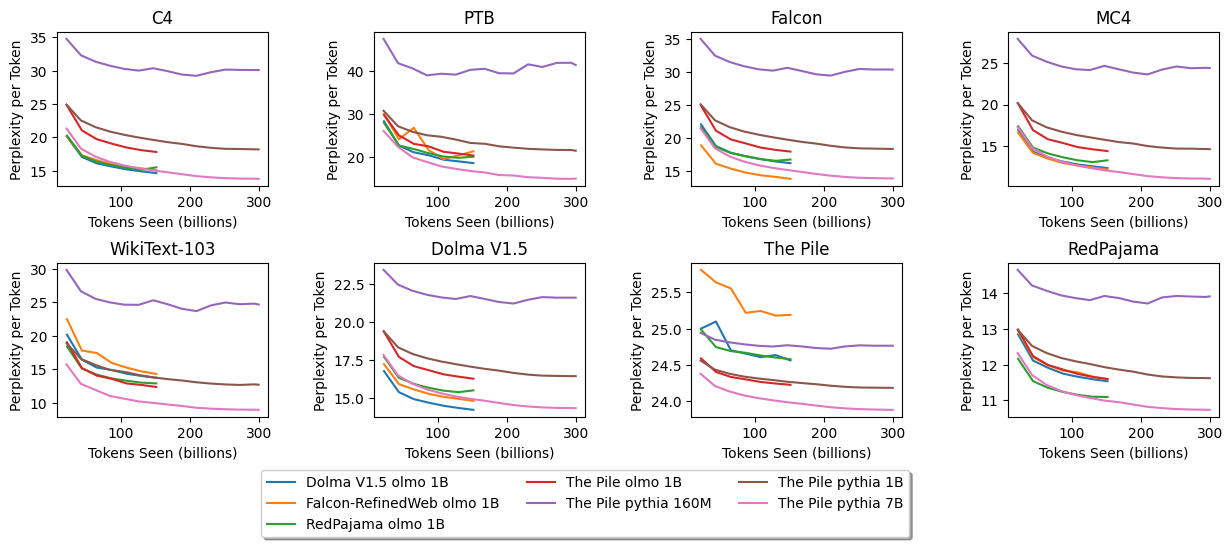

In [12]:
# all models over just one task

import matplotlib.pyplot as plt
import numpy as np

# one subplot for each task

fig, axs = plt.subplots(len(all_standard_tasks)//4, 4, figsize=(15, 5), gridspec_kw={'hspace': 0.5, 'wspace': 0.5})

for i, task_name in enumerate(all_standard_tasks):
    

    models_over_one_task = get_task_metric_for_all_models(model_name_to_path, task_name, metric_name)

    for (model, model_size, training_dataset), model_df in models_over_one_task.groupby(['model', 'model_size', 'training_dataset']):
        x_axis = model_df['tokens_seen'] / 1000000000
        y_axis = model_df[task_name]
        axs[i//4][i%4].plot(x_axis, y_axis, label=(training_dataset+' '+model+ f" {display_size(model_size)}"))
    axs[i//4][i%4].set_xlabel("Tokens Seen (billions)")
    axs[i//4][i%4].set_ylabel(name_to_display[metric_name])
    axs[i//4][i%4].set_title(name_to_display[task_name])
axs[-1][0].legend(loc='upper center', bbox_to_anchor=(2.5, -0.3),
        ncol=3, fancybox=True, shadow=True)
        # plt.plot(model_df['tokens_seen'] / 1000000000, model_df[task_name], label=(training_dataset+' '+model+ f" {model_size/1000000000:.0f}B"))
    # plt.legend()
# models_over_one_task = get_task_metric_for_all_models(model_name_to_path, 'ppl_dolma-v1_5', 'bits_per_byte')
# models_over_one_task

fig.savefig(os.path.join(FIGURE_DIR,'models_by_standard_benchmark.pdf'), bbox_inches='tight', dpi=300)


## Multi-domain Robustness

In [13]:
# # find the domains that improve the most and least over training per model

# import matplotlib.pyplot as plt
# import numpy as np

# # one subplot for each model
# # fig, axs = plt.subplots(len(model_name_to_path), 2, figsize=(15, 15), gridspec_kw={'hspace': 0.5, 'wspace': 0.5})

# # line chare for each model
# for i, (model_name, model) in enumerate(model_name_to_path.items()):
#     model_path = os.path.join(RESULTS_DIR, model)
#     all_subdomains = get_metric_for_all_subdomains(model_path, results_files_clean, metric_name, domains_without_subdomains_clean)
#     max_tokens_seen_row = all_subdomains[all_subdomains['tokens_seen'] == all_subdomains['tokens_seen'].max()].reset_index(drop=True).drop(columns=shared_cols).T.rename(columns={0: 'metric'})
#     min_tokens_seen_row = all_subdomains[all_subdomains['tokens_seen'] == all_subdomains['tokens_seen'].min()].reset_index(drop=True).drop(columns=shared_cols).T.rename(columns={0: 'metric'})
#     ratio_by_subdomain = max_tokens_seen_row / min_tokens_seen_row
#     break
# #     domains_by_final_ppl = list(max_tokens_seen_row.sort_values(by='metric', axis=0).index)
    
# #     for j in range(6):
# #         for subdomain in domains_by_final_ppl[j*100:j*100+100]:
# #             x_axis = all_subdomains['tokens_seen'] / 1000000000
# #             y_axis = all_subdomains[subdomain]
# #             axs[i][j].plot(x_axis, y_axis, label=subdomain)
# #         axs[i][j].set_xlabel("Tokens Seen (billions)")
# #         axs[i][j].set_ylabel(name_to_display[metric_name])
# #     # axs[i].legend(loc='upper center', bbox_to_anchor=(0.5, .95),
# #     #       ncol=3, fancybox=True, shadow=True)
# #     axs[i][3].set_title(model_name)
# # plt.show()

# # fig.savefig(os.path.join(FIGURE_DIR,'curves_for_all_subdomains.pdf'), bbox_inches='tight', dpi=300)
# ratio_by_subdomain.sort_values(by='metric', axis=0)[-50:].plot.bar(figsize=(10, 10))

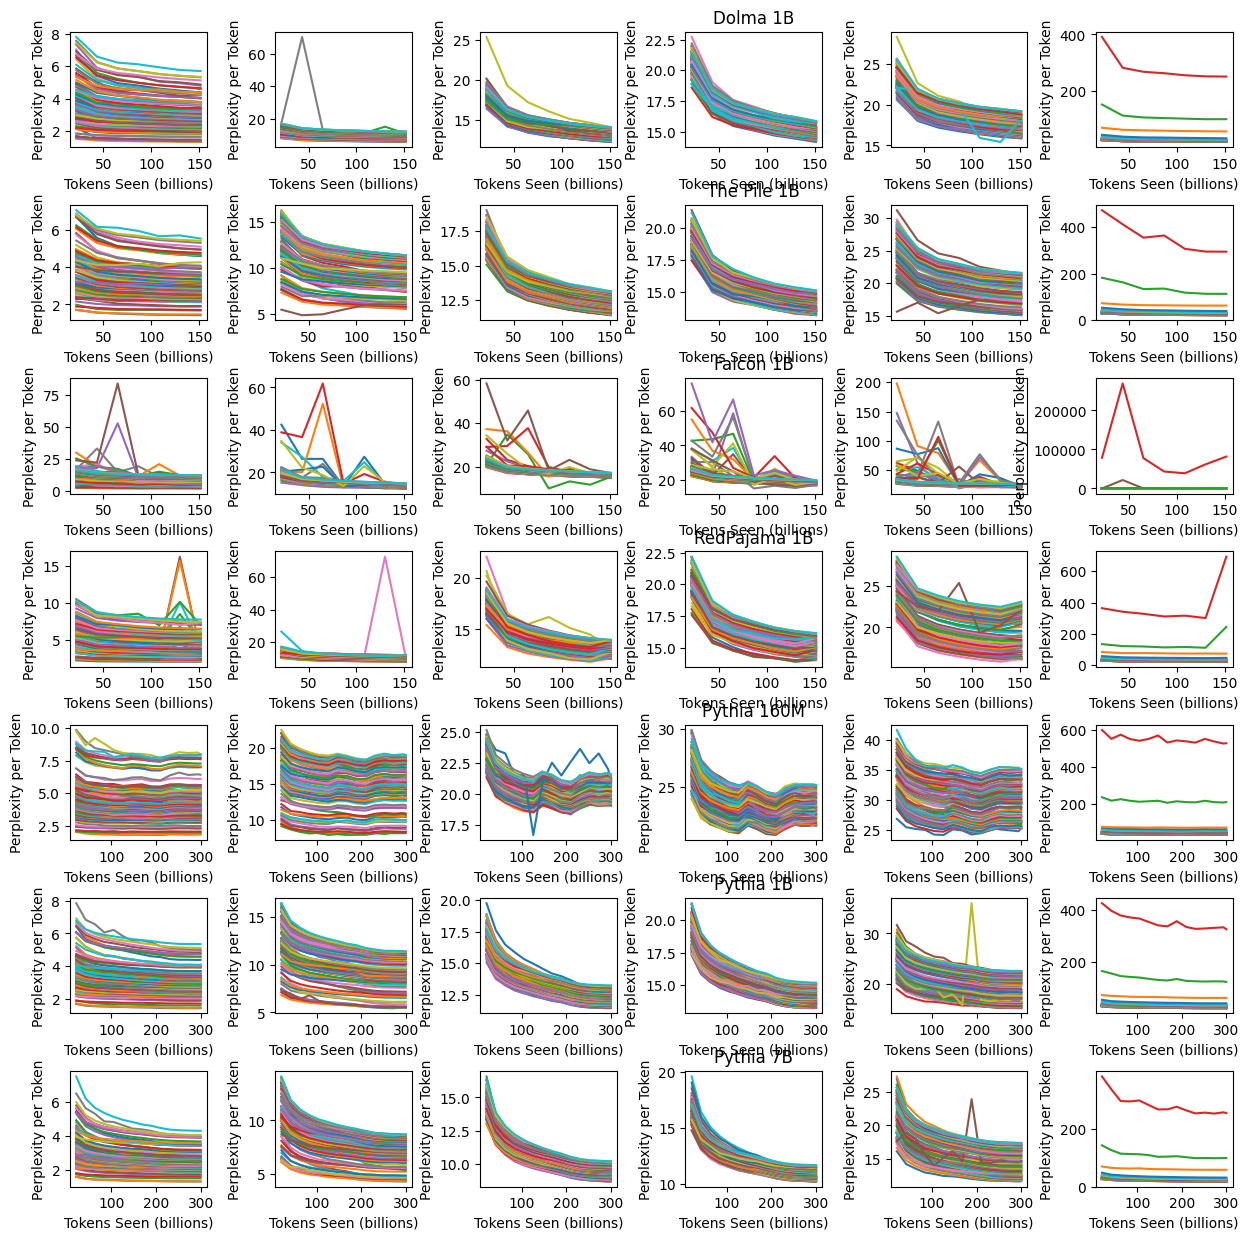

In [14]:
# one subplot per model, with lines for each subdomain

import matplotlib.pyplot as plt
import numpy as np

# one subplot for each model
fig, axs = plt.subplots(len(model_name_to_path), 6, figsize=(15, 15), gridspec_kw={'hspace': 0.5, 'wspace': 0.5})

# line chare for each model
for i, (model_name, model) in enumerate(model_name_to_path.items()):
    model_path = os.path.join(RESULTS_DIR, model)
    all_subdomains = get_metric_for_all_subdomains(model_path, results_files_clean, metric_name, domains_without_subdomains_clean)
    max_tokens_seen_row = all_subdomains[all_subdomains['tokens_seen'] == all_subdomains['tokens_seen'].max()].reset_index(drop=True).drop(columns=shared_cols).T.rename(columns={0: 'metric'})
    domains_by_final_ppl = list(max_tokens_seen_row.sort_values(by='metric', axis=0).index)
    
    for j in range(6):
        for subdomain in domains_by_final_ppl[j*100:j*100+100]:
            x_axis = all_subdomains['tokens_seen'] / 1000000000
            y_axis = all_subdomains[subdomain]
            axs[i][j].plot(x_axis, y_axis, label=subdomain)
        axs[i][j].set_xlabel("Tokens Seen (billions)")
        axs[i][j].set_ylabel(name_to_display[metric_name])
    # axs[i].legend(loc='upper center', bbox_to_anchor=(0.5, .95),
    #       ncol=3, fancybox=True, shadow=True)
    axs[i][3].set_title(name_to_display[model_name])
plt.show()

fig.savefig(os.path.join(FIGURE_DIR,'curves_for_all_subdomains.pdf'), bbox_inches='tight', dpi=300)


In [162]:
results_files_all

['ppl_token_ppl_dolma_100_programing_languages_subdomains.jsonl.gz',
 'ppl_byte_ppl_twitterAAE_HELM_fixed_subdomains.jsonl.gz',
 'ppl_ptb_token_count_avg_logits.jsonl.gz',
 'ppl_redpajama_token_count_avg_logits.jsonl.gz',
 'ppl_word_ppl_c4_100_domains_subdomains.jsonl.gz',
 'ppl_dolma_100_subreddits_token_count_avg_logits.jsonl.gz',
 'ppl_byte_ppl_redpajama_subdomains.jsonl.gz',
 'ppl_char_ppl_m2d2_wikipedia_unsplit_subdomains.jsonl.gz',
 'bits_per_byte_ppl_pile_subdomains.jsonl.gz',
 'ppl_char_ppl_dolma_100_programing_languages_subdomains.jsonl.gz',
 'ppl_byte_ppl_dolma_100_programing_languages_subdomains.jsonl.gz',
 'bits_per_byte_ppl_dolma_100_programing_languages_subdomains.jsonl.gz',
 'ppl_char_ppl_m2d2_s2orc_unsplit_subdomains.jsonl.gz',
 'bits_per_byte_ppl_c4_100_domains_subdomains.jsonl.gz',
 'ppl_char_ppl_ice_fixed_subdomains.jsonl.gz',
 'ppl_dolma-v1_5_token_count_avg_logits.jsonl.gz',
 'ppl_word_ppl_ice_fixed_subdomains.jsonl.gz',
 'ppl_4chan_meta_sep_token_count_avg_logits.

['ppl_token_ppl_dolma_100_programing_languages_subdomains.jsonl.gz',
 'ppl_token_ppl_m2d2_wikipedia_unsplit_subdomains.jsonl.gz',
 'ppl_token_ppl_dolma_100_subreddits_subdomains.jsonl.gz',
 'ppl_token_ppl_c4_100_domains_subdomains.jsonl.gz',
 'ppl_token_ppl_m2d2_s2orc_unsplit_subdomains.jsonl.gz']

In [172]:
# a table ranking models by macro avg or win rate over subdomains from given tasks
def get_task_subdomains_results_files(results_files, metric_name, task_name):
    if task_name == 'All':
        # results_files_all_modified = [f for f in results_files_all if "ppl_dolma_100_programing_languages" not in f] # not decontaminated so remove from "all"
        # results_files_all_modified = [f for f in results_files_all_modified if "ppl_ice_fixed" not in f] # not public so remove from "all"
        # results_files_all_modified = [f for f in results_files_all_modified if "ppl_pile" not in f] # try without this since it bloews up falcon
        def test_func(x):
            return ('ppl_m2d2_s2orc_unsplit' in x or 'ppl_m2d2_wikipedia' in x or 'ppl_dolma_100_subreddits' in x or 'ppl_c4_100_domains' in x) and x.startswith('ppl_token')
        results_files_all_modified = [f for f in results_files_all if test_func(f)]
        return results_files_all_modified
    return [f for f in results_files if f.startswith(metric_name) and f.endswith(task_name + '_subdomains.jsonl.gz')]


def make_ranking_table(agg_function, metric_name, model_name_to_path, include_all_checkpoints=False, tasks=None):    
    tasks = list(domains_with_subdomains_clean) + ['All'] if tasks is None else tasks
    tasks_without_subdomains = set(task for task in tasks if task in domains_without_subdomains or task == 'ppl_manosphere_meta_sep')
    tasks_to_files = {
        task: get_task_subdomains_results_files(results_files_clean, metric_name, task) for task in tasks if task not in domains_without_subdomains and task != 'ppl_manosphere_meta_sep'
    }

    assert agg_function in {get_avg_over_all_subdomains, get_win_rate_over_all_subdomains, get_median_over_all_subdomains}
    if include_all_checkpoints:
        assert agg_function != get_win_rate_over_all_subdomains, 'win rates dont make sense for all checkpoints'
    all_dfs = []
    for task in tasks:
        all_models_dfs = []
        for i, (model_name, model) in enumerate(model_name_to_path.items()):
            model_path = os.path.join(RESULTS_DIR, model)
            if task in tasks_without_subdomains:
                task_all_subdomains = get_metric_for_all_subdomains(model_path, [], metric_name, {task_name})
                # continue 
            else:
                files = tasks_to_files[task]
                try:
                    task_all_subdomains = get_metric_for_all_subdomains(model_path, files, metric_name)
                except ValueError as e:
                    raise ValueError(f"Error for {task} {model_name} {model_path} {files}") from e
            # get just the final checkpoints by tokens seen for each model
            if not include_all_checkpoints:
                task_all_subdomains = task_all_subdomains.sort_values(by=['tokens_seen']).groupby(['model','model_size']).last().reset_index()
            all_models_dfs.append(task_all_subdomains)
        assert len(all_models_dfs), f"empty for {task}"
        all_models_dfs = pd.concat(all_models_dfs)
        all_models_dfs = agg_function(all_models_dfs)
        if 'avg_over_subdomains' in all_models_dfs:
            all_models_dfs.rename(columns={'avg_over_subdomains': task}, inplace=True)
        if 'win_rate_over_subdomains' in all_models_dfs:
            all_models_dfs.rename(columns={'win_rate_over_subdomains': task}, inplace=True)
        if 'median_over_subdomains' in all_models_dfs:
            all_models_dfs.rename(columns={'median_over_subdomains': task}, inplace=True)
        all_dfs.append(all_models_dfs)
    all_dfs = reduce(lambda left,right: pd.merge(left,right,on=list(shared_cols), how='outer'), all_dfs)

    return all_dfs


In [173]:
model_name_to_path_1b = {k: v for k, v in model_name_to_path.items() if '1b' in k and k != 'pythia-1b'}
rankings_table = make_ranking_table(get_win_rate_over_all_subdomains, metric_name, model_name_to_path_1b).drop(columns=['tokens_seen','training_steps','split'])
rankings_table.rename(columns=name_to_display, inplace=True)
column_format = ('p{'+ str(1/ len(rankings_table.columns)*.5)+'\\textwidth}') * len(rankings_table.columns)
formaters = {name_to_display['model_size']: lambda x: display_size(x)}
rankings_table.to_latex(os.path.join(TABLES_DIR, 'final_checkpoints_1b_win_rates_per_tasks.tex'), index=False, float_format="%.2f", column_format=column_format, formatters=formaters)
rankings_table

,Training Dataset,Model Size,Model,ICE,M2D2 Wikipedia,100 Subreddits,M2D2 S2ORC,C4 100 Domains,100 PLs,Twitter AAE,The Pile,RedPajama,Dolma V1.5,All
0,Dolma V1.5,1177240704,olmo,0.000000,0.000000,1.0,0.000000,0.191919,0.65,0.0,0.000000,0.142857,0.5,0.286747
1,The Pile,1177240704,olmo,0.882353,0.306122,0.0,0.994012,0.040404,0.35,0.0,0.909091,0.571429,0.5,0.445783
2,Falcon-RefinedWeb,1177240704,olmo,0.058824,0.000000,0.0,0.000000,0.565657,0.00,1.0,0.045455,0.000000,0.0,0.134940
3,RedPajama,1177240704,olmo,0.058824,0.693878,0.0,0.005988,0.202020,0.00,0.0,0.045455,0.285714,0.0,0.132530


In [17]:
model_name_to_path_7b = {k: v for k, v in model_name_to_path.items() if '7b' in k or '6.9b' in k}
rankings_table = make_ranking_table(get_win_rate_over_all_subdomains, metric_name, model_name_to_path_7b).drop(columns=['tokens_seen','training_steps','split'])
rankings_table.rename(columns=name_to_display, inplace=True)
column_format = ('p{'+ str(1/ len(rankings_table.columns)*.5)+'\\textwidth}') * len(rankings_table.columns)
formaters = {name_to_display['model_size']: lambda x: display_size(x)}
rankings_table.to_latex(os.path.join(TABLES_DIR, 'final_checkpoints_7b_win_rates_per_tasks.tex'), index=False, float_format="%.2f", column_format=column_format, formatters=formaters)
rankings_table

,Training Dataset,Model Size,Model,ICE,M2D2 Wikipedia,100 Subreddits,M2D2 S2ORC,C4 100 Domains,100 PLs,Twitter AAE,The Pile,RedPajama,Dolma V1.5,All
0,The Pile,6444163072,pythia,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0


In [18]:
model_name_to_path_7b = {k: v for k, v in model_name_to_path.items() if 'pythia' in k}
rankings_table = make_ranking_table(get_win_rate_over_all_subdomains, metric_name, model_name_to_path_7b).drop(columns=['tokens_seen','training_steps','split'])
rankings_table.rename(columns=name_to_display, inplace=True)
column_format = ('p{'+ str(1/ len(rankings_table.columns)*.5)+'\\textwidth}') * len(rankings_table.columns)
formaters = {name_to_display['model_size']: lambda x: display_size(x)}
# rankings_table.to_latex(os.path.join(TABLES_DIR, 'final_checkpoints_7b_win_rates_per_tasks.tex'), index=False, float_format="%.2f", column_format=column_format, formatters=formaters)
rankings_table

,Training Dataset,Model Size,Model,ICE,M2D2 Wikipedia,100 Subreddits,M2D2 S2ORC,C4 100 Domains,100 PLs,Twitter AAE,The Pile,RedPajama,Dolma V1.5,All
0,The Pile,85056000,pythia,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,The Pile,805736448,pythia,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,The Pile,6444163072,pythia,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0


In [19]:
model_name_to_path_7b = {k: v for k, v in model_name_to_path.items() if 'dolma' in k}
rankings_table = make_ranking_table(get_win_rate_over_all_subdomains, metric_name, model_name_to_path_7b).drop(columns=['tokens_seen','training_steps','split'])
rankings_table.rename(columns=name_to_display, inplace=True)
column_format = ('p{'+ str(1/ len(rankings_table.columns)*.5)+'\\textwidth}') * len(rankings_table.columns)
formaters = {name_to_display['model_size']: lambda x: display_size(x)}
# rankings_table.to_latex(os.path.join(TABLES_DIR, 'final_checkpoints_7b_win_rates_per_tasks.tex'), index=False, float_format="%.2f", column_format=column_format, formatters=formaters)
rankings_table

,Training Dataset,Model Size,Model,ICE,M2D2 Wikipedia,100 Subreddits,M2D2 S2ORC,C4 100 Domains,100 PLs,Twitter AAE,The Pile,RedPajama,Dolma V1.5,All
0,Dolma V1.5,1177240704,olmo,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0


In [20]:
rankings_table = make_ranking_table(get_avg_over_all_subdomains, metric_name, model_name_to_path,).drop(columns=['tokens_seen','training_steps','split'])
rankings_table.rename(columns=name_to_display, inplace=True)
column_format = ('p{'+ str(1/ len(rankings_table.columns)*.5)+'\\textwidth}') * len(rankings_table.columns)
formaters = {name_to_display['model_size']: lambda x: display_size(x)}
rankings_table.to_latex(os.path.join(TABLES_DIR, 'final_checkpoints_avg_ppl_per_tasks.tex'), index=False, float_format="%.2f", column_format=column_format, formatters=formaters)
rankings_table

,Training Dataset,Model Size,Model,ICE,M2D2 Wikipedia,100 Subreddits,M2D2 S2ORC,C4 100 Domains,100 PLs,Twitter AAE,The Pile,RedPajama,Dolma V1.5,All
0,Dolma V1.5,1177240704,olmo,15.487544,13.398732,20.325492,14.205593,13.338549,3.572524,175.348682,12.071563,9.529943,12.609195,15.943139
1,The Pile,1177240704,olmo,15.098326,12.602586,23.547606,12.277987,14.706735,3.854354,203.305005,8.450213,8.549489,13.280128,16.104397
2,Falcon-RefinedWeb,1177240704,olmo,21.337623,13.641269,24.652996,16.697323,13.265275,32.092361,169.487323,3732.187010,21.121045,16.848770,195.585522
3,RedPajama,1177240704,olmo,15.526775,12.376437,25.385918,14.508589,13.608215,5.372171,468.556110,12.198283,8.326343,14.190600,18.406568
4,The Pile,85056000,pythia,24.718647,21.847392,38.179903,19.873386,24.980322,5.249504,369.915630,13.563294,13.739477,21.644417,26.650940
5,The Pile,805736448,pythia,15.445682,12.654877,24.558751,12.339637,15.015606,3.749775,224.727703,8.265756,8.662201,13.491730,16.519013
6,The Pile,6444163072,pythia,12.233094,9.261965,18.866162,9.706912,11.378526,3.232354,176.427283,6.226319,6.743793,10.382739,12.706940


In [21]:
all_domains

{'ppl_4chan_meta_sep',
 'ppl_c4_100_domains',
 'ppl_c4_en',
 'ppl_dolma-v1_5',
 'ppl_dolma_100_programing_languages',
 'ppl_dolma_100_subreddits',
 'ppl_falcon-refinedweb',
 'ppl_gab',
 'ppl_ice_fixed',
 'ppl_m2d2_s2orc_unsplit',
 'ppl_m2d2_wikipedia_unsplit',
 'ppl_manosphere_meta_sep',
 'ppl_mc4',
 'ppl_pile',
 'ppl_ptb',
 'ppl_redpajama',
 'ppl_twitterAAE_HELM_fixed',
 'ppl_wikitext_103'}

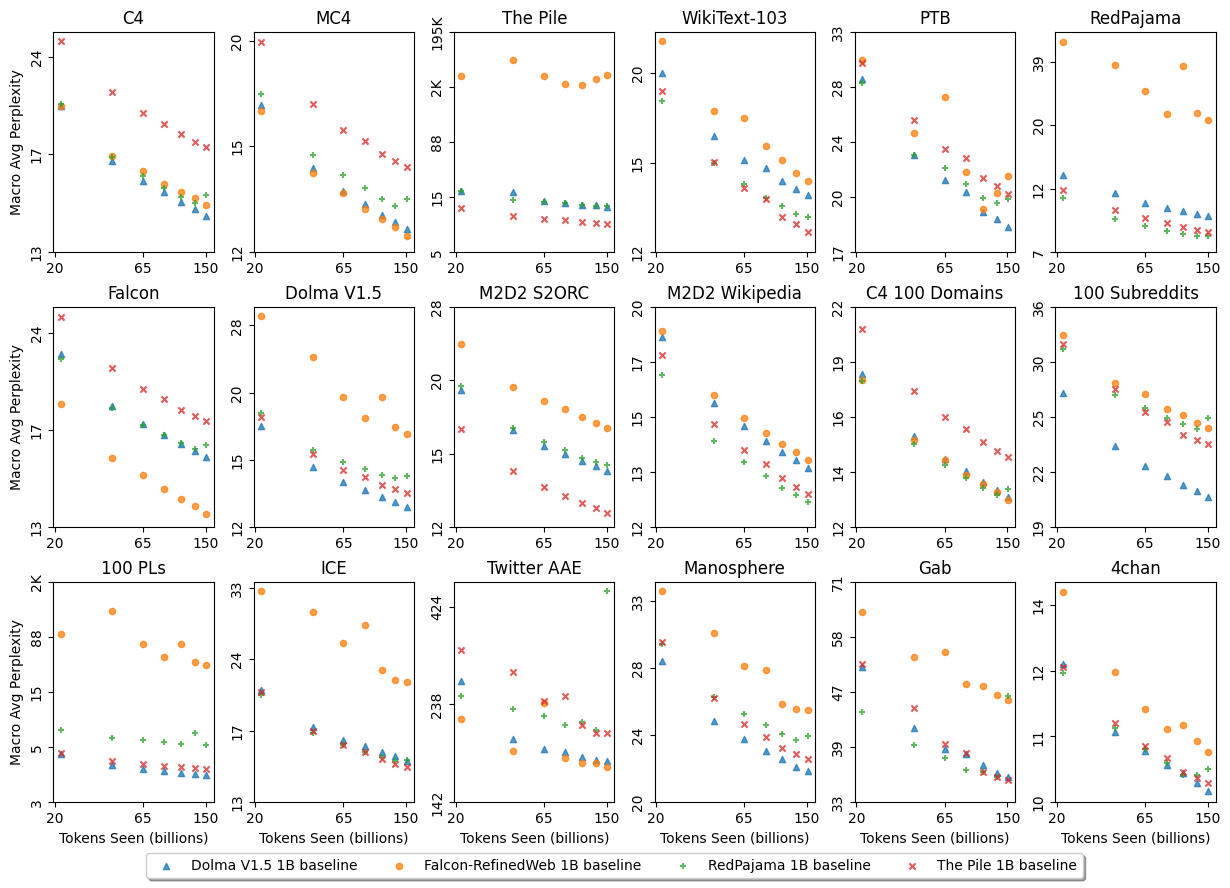

In [217]:
import matplotlib.pyplot as plt
import numpy as np

cols = 6
domains = ['ppl_'+domain for domain in domain_order]
models = {k:v for k,v in model_name_to_path.items() if k in trained_baseline_models}
# one subplot for each task
fig, axs = plt.subplots(len(domains)//cols + int(len(domains)//cols < len(domains)/cols), cols, figsize=(15, 10), gridspec_kw={'hspace': 0.25, 'wspace': 0.25})

for i, task_name in enumerate(domains):
    
    models_over_one_task = make_ranking_table(get_avg_over_all_subdomains, metric_name, models,include_all_checkpoints=True, tasks=[task_name])
    for (model, model_size, training_dataset), model_df in models_over_one_task.groupby(['model', 'model_size', 'training_dataset']):
        x_axis = model_df['tokens_seen'] / 1000000000
        y_axis = model_df[task_name]
        y_axis = np.log(np.log(y_axis))
        axs[i//cols][i%cols].scatter(x_axis, y_axis, label=(training_dataset+ f" {display_size(model_size)} baseline"), s=20, alpha=0.75, marker=model_dataset_names_to_marker[training_dataset+' '+model+ f" {display_size(model_size)}"])
    if i // cols == len(axs) - 1:
        axs[i//cols][i%cols].set_xlabel("Tokens Seen (billions)")
    axs[i//cols][i%cols].set_xscale('log')
    axs[i//cols][i%cols].xaxis.set_minor_locator(plt.NullLocator())
    xticks = [20, 65, 150]
    axs[i//cols][i%cols].set_xticks(xticks)
    axs[i//cols][i%cols].set_xticklabels([str(x) for x in xticks])

    if i % cols == 0:
        axs[i//cols][i%cols].set_ylabel("Macro Avg Perplexity")
    # axs[i//cols][i%cols].set_ylabel("Macro Avg Perplexity") # +name_to_display[metric_name])
    y_ticks = axs[i//cols][i%cols].get_yticks()[::2]
    y_ticks_transformed = np.exp(np.exp(y_ticks))
    axs[i//cols][i%cols].set_yticks(y_ticks)
    axs[i//cols][i%cols].set_yticklabels([human_readable_int(y) for y in y_ticks_transformed], rotation='vertical', ha='right', va='center')
    axs[i//cols][i%cols].set_title(name_to_display[task_name])
axs[-1][0].legend(loc='upper center', bbox_to_anchor=(3.5, -0.2),
        ncol=4, fancybox=True, shadow=True)

fig.savefig(os.path.join(FIGURE_DIR,'models_by_macro_subdomains.pdf'), bbox_inches='tight', dpi=300)

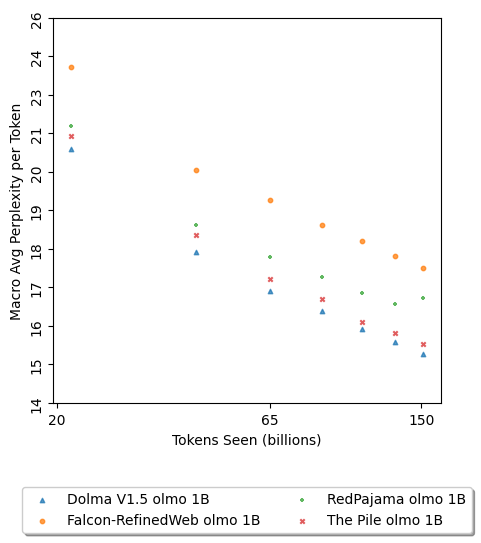

In [197]:
import matplotlib.pyplot as plt
import numpy as np

cols = 1
domains = list(['All'])
models = {k:v for k,v in model_name_to_path.items() if k in trained_baseline_models}
# one subplot for each task
fig, axs = plt.subplots(len(domains)//cols + int(len(domains)//cols < len(domains)/cols), cols, figsize=(5, 5), gridspec_kw={'hspace': 0.5, 'wspace': 0.5})
axs = [[axs]]

for i, task_name in enumerate(domains):
    
    models_over_one_task = make_ranking_table(get_avg_over_all_subdomains, metric_name, models,include_all_checkpoints=True, tasks=[task_name]) # get_avg_over_all_subdomains

    for (model, model_size, training_dataset), model_df in models_over_one_task.groupby(['model', 'model_size', 'training_dataset']):
        x_axis = model_df['tokens_seen'] / 1000000000
        y_axis = model_df[task_name]
        y_axis = np.log(np.log(y_axis))
        axs[i//cols][i%cols].scatter(x_axis, y_axis, label=(training_dataset+' '+model+ f" {display_size(model_size)}"), s=10, alpha=0.75, marker=model_dataset_names_to_marker[training_dataset+' '+model+ f" {display_size(model_size)}"])
    axs[i//cols][i%cols].set_xlabel("Tokens Seen (billions)")
    axs[i//cols][i%cols].set_xscale('log')
    axs[i//cols][i%cols].xaxis.set_minor_locator(plt.NullLocator())
    xticks = [20, 65, 150]
    axs[i//cols][i%cols].set_xticks(xticks)
    axs[i//cols][i%cols].set_xticklabels([str(x) for x in xticks])
    
    axs[i//cols][i%cols].set_ylabel("Macro Avg " +name_to_display[metric_name])
    y_ticks = axs[i//cols][i%cols].get_yticks()
    y_ticks_transformed = np.exp(np.exp(y_ticks))
    axs[i//cols][i%cols].set_yticks(y_ticks)
    axs[i//cols][i%cols].set_yticklabels([human_readable_int(y) for y in y_ticks_transformed], rotation='vertical', ha='right', va='center')

    # axs[i//cols][i%cols].set_title(name_to_display[task_name])
axs[-1][0].legend(loc='upper center', bbox_to_anchor=(0.5, -0.2),
        ncol=2, fancybox=True, shadow=True)

fig.savefig(os.path.join(FIGURE_DIR,'models_by_macro_subdomains_all.pdf'), bbox_inches='tight', dpi=300)

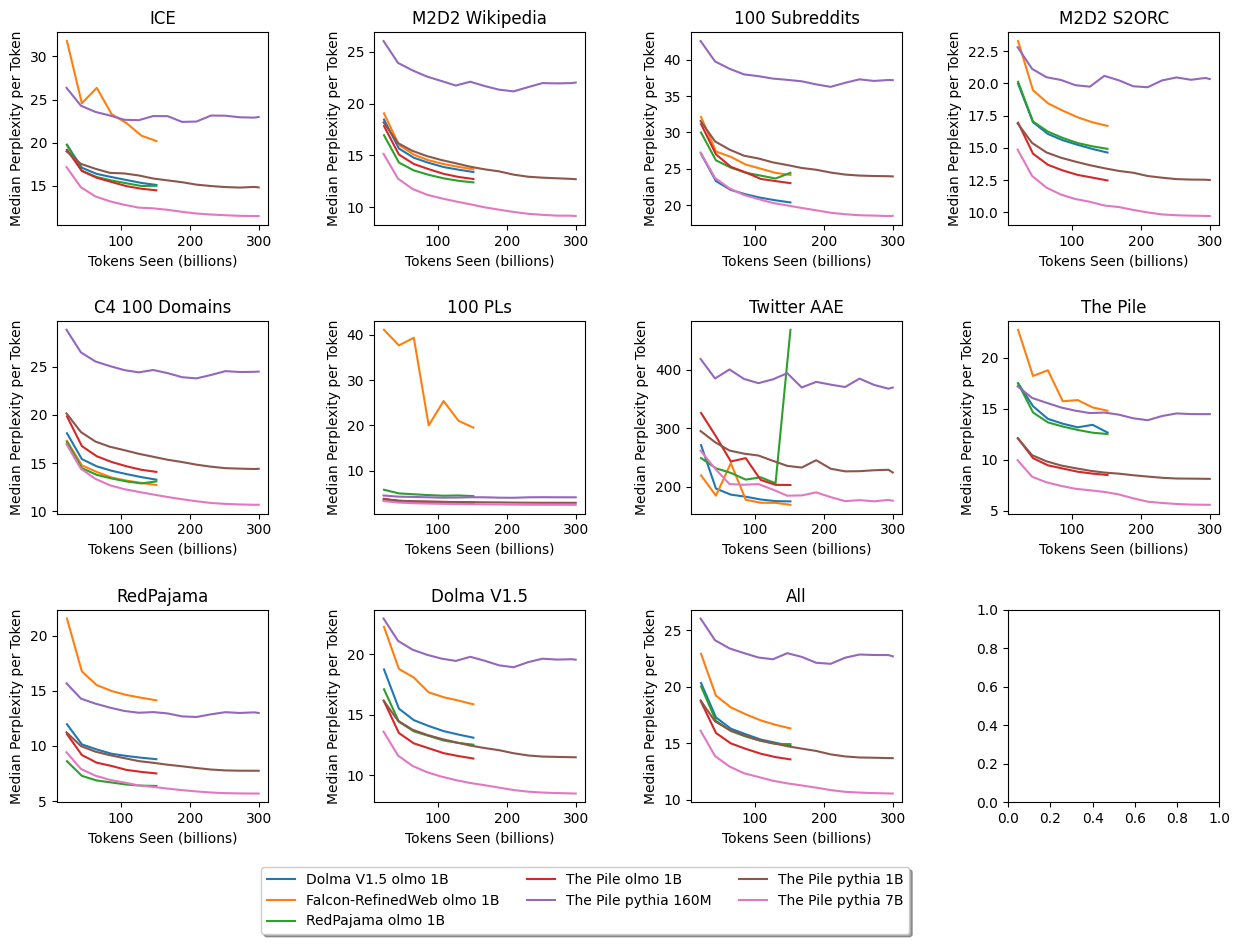

In [25]:
import matplotlib.pyplot as plt
import numpy as np

cols = 4
# one subplot for each task
fig, axs = plt.subplots(len(list(domains_with_subdomains_clean) + ['All'])//cols + int(len(list(domains_with_subdomains_clean) + ['All'])//cols < len(list(domains_with_subdomains_clean) + ['All'])/cols), cols, figsize=(15, 10), gridspec_kw={'hspace': 0.5, 'wspace': 0.5})

for i, task_name in enumerate(list(domains_with_subdomains_clean) + ['All']):
    
    models_over_one_task = make_ranking_table(get_median_over_all_subdomains, metric_name, model_name_to_path,include_all_checkpoints=True, tasks=[task_name])

    for (model, model_size, training_dataset), model_df in models_over_one_task.groupby(['model', 'model_size', 'training_dataset']):
        x_axis = model_df['tokens_seen'] / 1000000000
        y_axis = model_df[task_name]
        axs[i//cols][i%cols].plot(x_axis, y_axis, label=(training_dataset+' '+model+ f" {display_size(model_size)}"))
    axs[i//cols][i%cols].set_xlabel("Tokens Seen (billions)")
    axs[i//cols][i%cols].set_ylabel("Median " +name_to_display[metric_name])
    axs[i//cols][i%cols].set_title(name_to_display[task_name])
axs[-1][0].legend(loc='upper center', bbox_to_anchor=(2.5, -0.3),
        ncol=3, fancybox=True, shadow=True)

fig.savefig(os.path.join(FIGURE_DIR,'models_by_median_subdomains.pdf'), bbox_inches='tight', dpi=300)

### Non-aggregated subdomain results

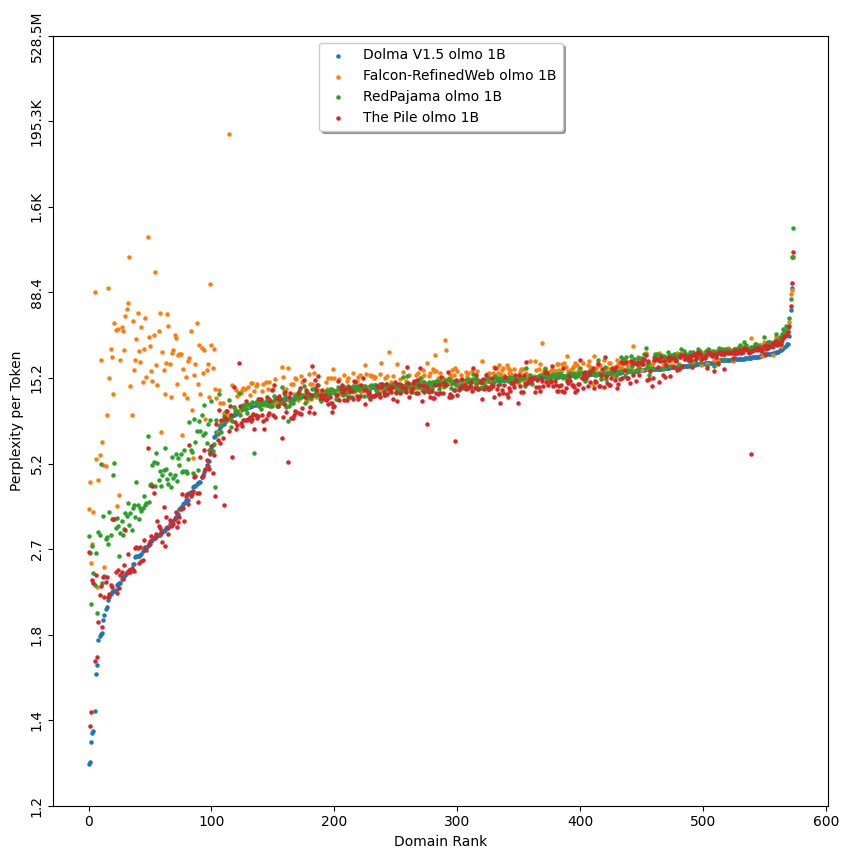

In [142]:
# sort domains by their performance on the final checkpoint of Dolma 7b, then scatter plot for each model in its own color ordered that way


# get subdomains in order of a model's BPB on the final checkpoint
model_name = 'dolma-1b'
model = model_name_to_path[model_name]
model_path = os.path.join(RESULTS_DIR, model)
all_subdomains = get_metric_for_all_subdomains(model_path, results_files_clean, metric_name, domains_without_subdomains_clean)
unaggred_subdomains= all_subdomains[all_subdomains['tokens_seen'] == all_subdomains['tokens_seen'].max()]
tmp_df = unaggred_subdomains.drop(columns=shared_cols)
assert len(tmp_df) == 1
dolma_domains_as_rows = tmp_df.T.rename(columns={tmp_df.T.columns[0]: 'metric'}).sort_values(by='metric', axis=0).index

# get all subdomains
unaggred_subdomains = []
models = {k:v for k,v in model_name_to_path.items() if k in trained_baseline_models}
for i, (model_name, model) in enumerate(models.items()):
    model_path = os.path.join(RESULTS_DIR, model)
    all_subdomains = get_metric_for_all_subdomains(model_path, results_files_clean, metric_name, domains_without_subdomains_clean)
    unaggred_subdomains.append(all_subdomains[all_subdomains['tokens_seen'] == all_subdomains['tokens_seen'].max()])

unaggred_subdomains = pd.concat(unaggred_subdomains)
sorted_unaggred_subdomains = unaggred_subdomains[list(shared_cols) + list(dolma_domains_as_rows)]

fig, axs = plt.subplots(1, 1, figsize=(10, 10))

for (model, model_size, training_dataset), model_df in sorted_unaggred_subdomains.groupby(['model', 'model_size', 'training_dataset']):
    y_axis = model_df[list(dolma_domains_as_rows)].values[0]
    x_axis = np.arange(len(dolma_domains_as_rows))
    y_axis = np.log(np.log(y_axis))
    # smaller scatter point size
    axs.scatter(x_axis, y_axis, label=(training_dataset+' '+model+ f" {display_size(model_size)}"), s=5)
axs.set_xlabel("Domain Rank")
axs.set_ylabel(name_to_display[metric_name])
y_ticks = axs.get_yticks()
y_ticks_transformed = np.exp(np.exp(y_ticks))
axs.set_yticks(y_ticks)
axs.set_yticklabels([human_readable_int(y, precision=1) for y in y_ticks_transformed], rotation='vertical', ha='right', va='center')
axs.legend(loc='upper center', ncol=1, fancybox=True, shadow=True)

fig.savefig(os.path.join(FIGURE_DIR,'subdomain_perf_ordered.pdf'), bbox_inches='tight', dpi=300)


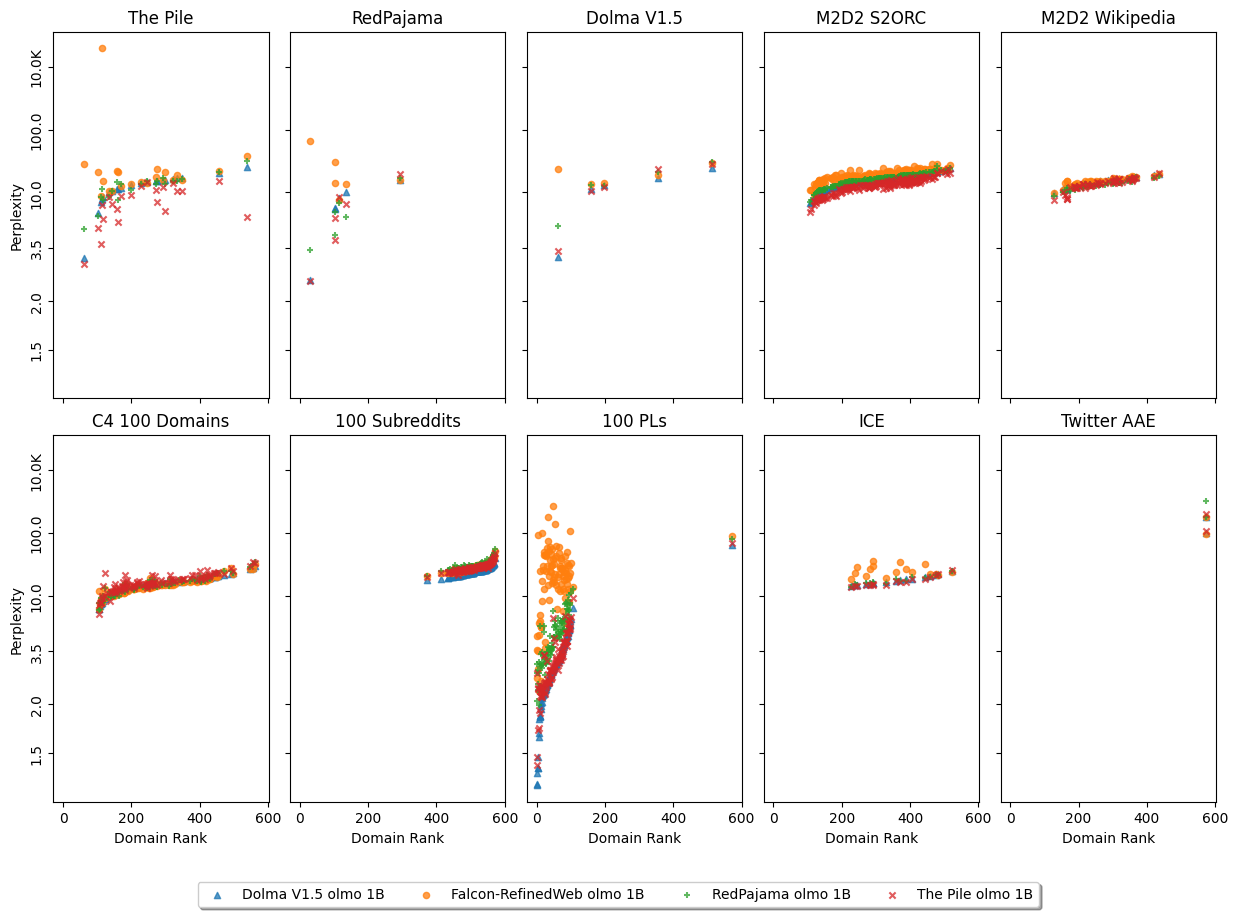

In [226]:
# do scatter plot colored by task for one model to show where tasks are in the performance distribution

# sort domains by their perf on the final checkpoint of Dolma 7b, then scatter plot for each model in its own color ordered that way

# get subdomains in order of a model's BPB on the final checkpoint
model_name = 'dolma-1b'
model = model_name_to_path[model_name]
model_path = os.path.join(RESULTS_DIR, model)
domains_by_tasks = {}
all_subdomains = get_metric_for_all_subdomains(model_path, results_files_clean, metric_name, domains_without_subdomains_clean)
unaggred_subdomains= all_subdomains[all_subdomains['tokens_seen'] == all_subdomains['tokens_seen'].max()]
tmp_df = unaggred_subdomains.drop(columns=shared_cols)
assert len(tmp_df) == 1
dolma_domains_as_rows = tmp_df.T.rename(columns={tmp_df.T.columns[0]: 'metric'}).sort_values(by='metric', axis=0).index

cols = 5
tasks = ['ppl_'+domain for domain in domain_order if ('ppl_'+domain) in (domains_with_subdomains - {'ppl_manosphere_meta_sep'})]
fig, axs = plt.subplots(len(tasks) // cols, cols, figsize=(15, 10), sharex=True, sharey=True, gridspec_kw={'hspace': 0.1, 'wspace': 0.1})

unaggred_subdomains = []
models = {k:v for k,v in model_name_to_path.items() if k in trained_baseline_models}
for i, (model_name, model) in enumerate(models.items()):
    model_path = os.path.join(RESULTS_DIR, model)
    all_subdomains = get_metric_for_all_subdomains(model_path, results_files_clean, metric_name, domains_without_subdomains_clean)
    unaggred_subdomains.append(all_subdomains[all_subdomains['tokens_seen'] == all_subdomains['tokens_seen'].max()])

unaggred_subdomains = pd.concat(unaggred_subdomains)
sorted_unaggred_subdomains = unaggred_subdomains[list(shared_cols) + list(dolma_domains_as_rows)]

# sorted_unaggred_subdomains = unaggred_subdomains[list(shared_cols) + list(dolma_domains_as_rows)]

for j, (task) in enumerate(tasks):
    domains = task_to_domains[task]
    for (model, model_size, training_dataset), model_df in sorted_unaggred_subdomains.groupby(['model', 'model_size', 'training_dataset']):
        domains_in_order = [domain for domain in dolma_domains_as_rows if domain in domains]
        y_axis = model_df[domains_in_order]
        x_axis = [i for i, domain in enumerate(dolma_domains_as_rows) if domain in domains]
        y_axis = np.log(np.log(y_axis))
        # smaller scatter point size
        axs[j//cols][j%cols].scatter(x_axis, y_axis, label=(training_dataset+' '+model+ f" {display_size(model_size)}"), s=20, alpha=0.75, marker=model_dataset_names_to_marker[training_dataset+' '+model+ f" {display_size(model_size)}"])
    if j // cols == len(axs) - 1:
        axs[j//cols][j%cols].set_xlabel("Domain Rank")
    # axs[j//cols][j%cols].set_xlabel("Domain Rank")
    if j % cols == 0:
        axs[j//cols][j%cols].set_ylabel("Perplexity")
    # axs[j//cols][j%cols].set_ylabel(name_to_display[metric_name])
    y_ticks = np.log(np.log([1.5, 2, 3.5, 10, 100, 10000]))
    y_ticks_transformed = np.exp(np.exp(y_ticks))
    axs[j//cols][j%cols].set_yticks(y_ticks)
    axs[j//cols][j%cols].set_yticklabels([human_readable_int(y, precision=1) for y in y_ticks_transformed], rotation='vertical', ha='right', va='center')
    axs[j//cols][j%cols].set_title(name_to_display[task])
    
axs[-1][0].legend(loc='upper center', bbox_to_anchor=(2.625, -0.2),
        ncol=4, fancybox=True, shadow=True)

fig.savefig(os.path.join(FIGURE_DIR,'subdomain_perf_ordered_by_task.pdf'), bbox_inches='tight', dpi=300)


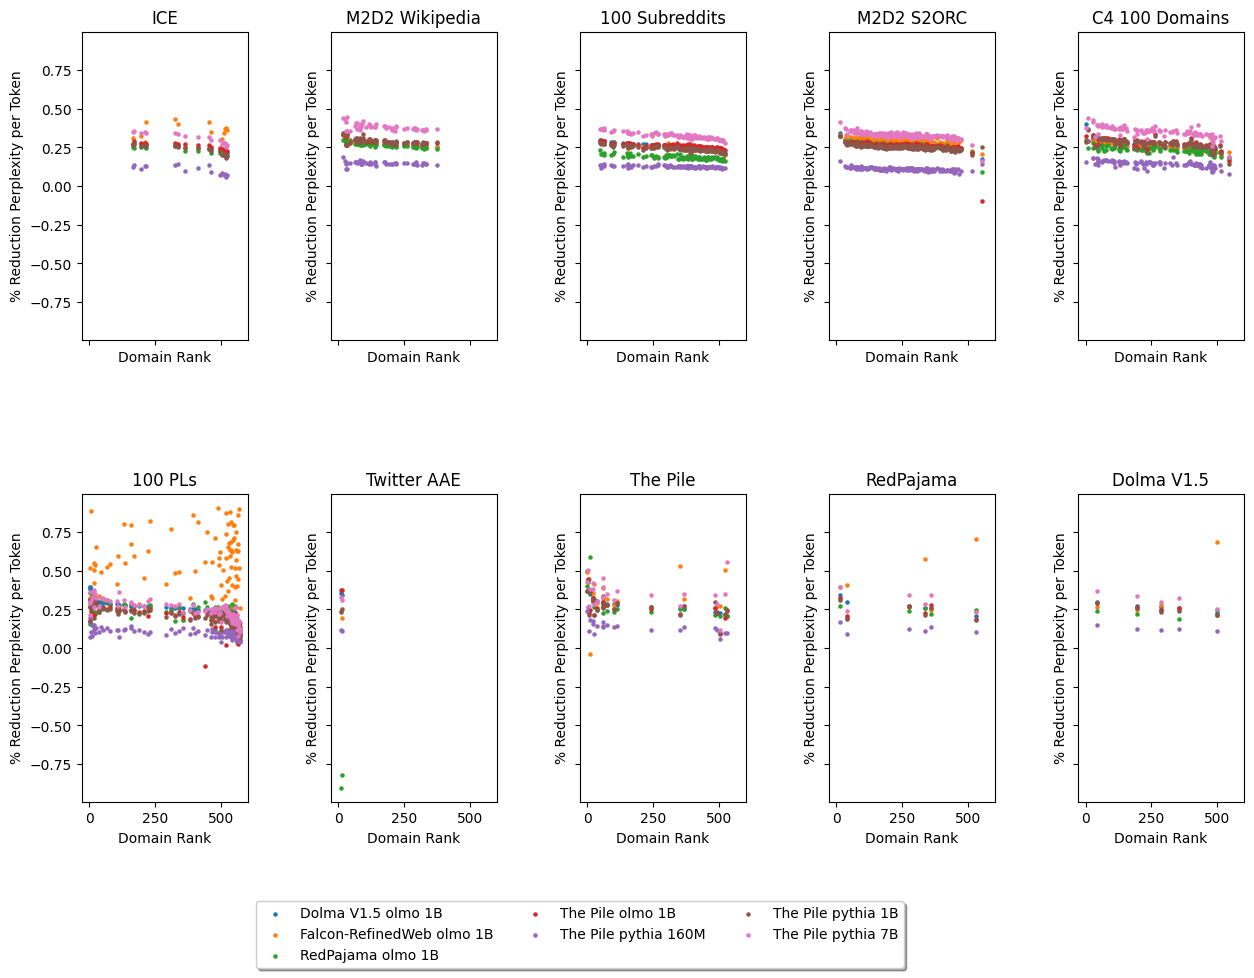

In [28]:
# do scatter plot colored by task for one model to show where tasks are in the rank of ratio of final to initial performance

# sort domains by their ratio of final to initial performance on the final checkpoint of Dolma 7b, then scatter plot for each model in its own color ordered that way

# get subdomains in order of a model's BPB on the final checkpoint
model_name = 'dolma-1b'
model = model_name_to_path[model_name]
model_path = os.path.join(RESULTS_DIR, model)
domains_by_tasks = {}
all_subdomains = get_metric_for_all_subdomains(model_path, results_files_clean, metric_name, domains_without_subdomains_clean)
max_all_subdomains = all_subdomains[all_subdomains['tokens_seen'] == all_subdomains['tokens_seen'].max()].reset_index(drop=True).drop(columns=shared_cols).T.rename(columns={0: 'metric'})
min_all_subdomains = all_subdomains[all_subdomains['tokens_seen'] == all_subdomains['tokens_seen'].min()].reset_index(drop=True).drop(columns=shared_cols).T.rename(columns={0: 'metric'})
ratio_by_subdomain = max_all_subdomains / min_all_subdomains
dolma_domains_as_rows = ratio_by_subdomain.sort_values(by='metric', axis=0).index

cols = 5
fig, axs = plt.subplots(len(task_to_domains) // cols, cols, figsize=(15, 10), sharex=True, sharey=True, gridspec_kw={'hspace': 0.5, 'wspace': 0.5})

unaggred_subdomains = []
for i, (model_name, model) in enumerate(model_name_to_path.items()):
    model_path = os.path.join(RESULTS_DIR, model)
    all_subdomains = get_metric_for_all_subdomains(model_path, results_files_clean, metric_name, domains_without_subdomains_clean)
    max_all_subdomains = all_subdomains[all_subdomains['tokens_seen'] == all_subdomains['tokens_seen'].max()].reset_index(drop=True)
    min_all_subdomains = all_subdomains[all_subdomains['tokens_seen'] == all_subdomains['tokens_seen'].min()].reset_index(drop=True)
    non_shared_cols = [col for col in all_subdomains.columns if col not in shared_cols]
    ratio_by_subdomain = 1 - max_all_subdomains[non_shared_cols] / min_all_subdomains[non_shared_cols]
    ratio_by_subdomain[list(shared_cols)] = max_all_subdomains[list(shared_cols)]
    unaggred_subdomains.append(ratio_by_subdomain)
unaggred_subdomains = pd.concat(unaggred_subdomains)
sorted_unaggred_subdomains = unaggred_subdomains[list(shared_cols) + list(dolma_domains_as_rows)]

# sorted_unaggred_subdomains = unaggred_subdomains[list(shared_cols) + list(dolma_domains_as_rows)]
for j, (task, domains) in enumerate(tasts_to_domains_clean.items()):
    for (model, model_size, training_dataset), model_df in sorted_unaggred_subdomains.groupby(['model', 'model_size', 'training_dataset']):
        domains_in_order = [domain for domain in dolma_domains_as_rows if domain in domains]
        y_axis = model_df[domains_in_order]
        x_axis = [i for i, domain in enumerate(dolma_domains_as_rows) if domain in domains]
        # smaller scatter point size
        axs[j//cols][j%cols].scatter(x_axis, y_axis, label=(training_dataset+' '+model+ f" {display_size(model_size)}"), s=5)
    axs[j//cols][j%cols].set_xlabel("Domain Rank")
    axs[j//cols][j%cols].set_ylabel("% Reduction " +name_to_display[metric_name])
    axs[j//cols][j%cols].set_title(name_to_display[task])
    # axs[j//cols][j%cols].set_ylim(0)
axs[-1][0].legend(loc='upper center', bbox_to_anchor=(3, -0.3),
        ncol=3, fancybox=True, shadow=True)

# fig.savefig(os.path.join(FIGURE_DIR,'subdomain_perf_ordered_by_task.pdf'), bbox_inches='tight', dpi=300)

### different improvement rates

pile-1b
ppl_m2d2_s2orc_unsplit
stat.ME   -0.098829
Name: 0, dtype: float64
pile-1b
ppl_dolma_100_programing_languages
45_pascal   -0.114282
Name: 0, dtype: float64
falcon-1b
ppl_pile
Ubuntu_IRC   -0.039048
Name: 0, dtype: float64
rpj-1b
ppl_twitterAAE_HELM_fixed
AA      -0.901763
white   -0.817622
Name: 0, dtype: float64


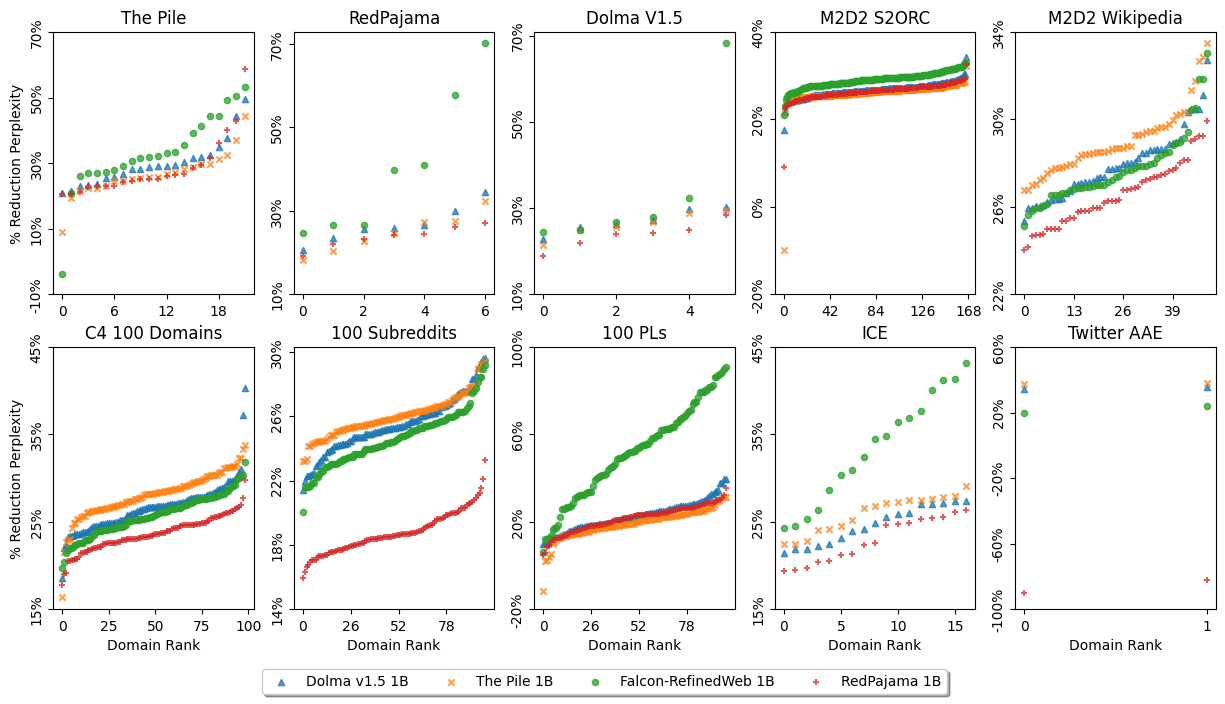

In [260]:
import matplotlib
cols = 5
models = {k:v for k,v in model_name_to_path.items() if k in trained_baseline_models}
tasks = ['ppl_'+domain for domain in domain_order if ('ppl_'+domain) in (domains_with_subdomains - {'ppl_manosphere_meta_sep'})]
fig, axs = plt.subplots(len(task_to_domains) // cols, cols, figsize=(15, 7.5), gridspec_kw={'hspace': 0.2, 'wspace': 0.2})
most_improved_domains = {}
least_improved_domains = {}
for i, (model_name, model) in enumerate(models.items()):
    most_improved_domains[model_name] = {}
    least_improved_domains[model_name] = {}
    for j, task_name in enumerate(tasks):
        task_files = get_task_subdomains_results_files(results_files_clean, metric_name, task_name)
        model_path = os.path.join(RESULTS_DIR, model)
        all_subdomains = get_metric_for_all_subdomains(model_path, task_files, metric_name)
        max_all_subdomains = all_subdomains[all_subdomains['tokens_seen'] == all_subdomains['tokens_seen'].max()].reset_index(drop=True)
        min_all_subdomains = all_subdomains[all_subdomains['tokens_seen'] == all_subdomains['tokens_seen'].min()].reset_index(drop=True)
        domains = list(tasts_to_domains_clean[task_name])
        ratio_by_subdomain = 1 - max_all_subdomains[domains] / min_all_subdomains[domains]
        ratio_by_subdomain_series = ratio_by_subdomain.iloc[0].T
        negative_reduction = ratio_by_subdomain_series[ratio_by_subdomain_series < 0.0]

        most_improved = ratio_by_subdomain_series.sort_values(ascending=False)
        most_improved_domains[model_name][task_name] = {}
        most_improved_domains[model_name][task_name]['domain'] = most_improved.index[0]
        most_improved_domains[model_name][task_name]['reduction'] = f"{most_improved.iloc[0]:.2%}"

        least_improved_domains[model_name][task_name] = {}
        least_improved_domains[model_name][task_name]['domain'] = most_improved.index[-1]
        least_improved_domains[model_name][task_name]['reduction'] = f"{most_improved.iloc[-1]:.2%}"
        
        if len(negative_reduction):
            print(model_name)
            print(task_name)
            print(negative_reduction)
        ratio_by_subdomain = ratio_by_subdomain.values.flatten()
        ratio_by_subdomain.sort()
        y_axis = ratio_by_subdomain
        x_axis = np.arange(len(ratio_by_subdomain))
        axs[j//cols][j%cols].scatter(x_axis, y_axis, label=(name_to_display[model_name]),  s=20, alpha=0.75, marker=model_name_to_marker[model_name])
        if j // cols == len(axs) - 1:
            axs[j//cols][j%cols].set_xlabel("Domain Rank")
        # axs[j//cols][j%cols].set_xlabel("Domain Rank")

        if j % cols == 0:
            axs[j//cols][j%cols].set_ylabel("% Reduction Perplexity")
        # axs[j//cols][j%cols].set_ylabel("% Reduction " +name_to_display[metric_name])
        axs[j//cols][j%cols].set_title(name_to_display[task_name])
        # x ticks as integers
        axs[j//cols][j%cols].xaxis.set_major_locator(matplotlib.ticker.MultipleLocator(len(ratio_by_subdomain)//4 + 1))
        # y ticks as percentages
        axs[j//cols][j%cols].yaxis.set_major_formatter(matplotlib.ticker.PercentFormatter(1.0, decimals=0))
        # print(len(ratio_by_subdomain))
        # axs[j//cols][j%cols].set_xlim(0, len(ratio_by_subdomain))

for j in range(len(tasks)):
    y_ticks = axs[j//cols][j%cols].get_yticks()[::2]
    axs[j//cols][j%cols].set_yticks(y_ticks)
    axs[j//cols][j%cols].set_yticklabels([f"{y:.0%}" for y in y_ticks], rotation='vertical', ha='right', va='center')

axs[-1][0].legend(loc='upper center', bbox_to_anchor=(2.75, -0.2),
        ncol=4, fancybox=True, shadow=True)


fig.savefig(os.path.join(FIGURE_DIR,'domains_by_reduction.pdf'), bbox_inches='tight', dpi=300)

In [54]:
def make_multi_index_df_from_dict(data_dict, subcolumn_names):
    # create a multi-index for the columns and rows
    columns = pd.MultiIndex.from_product([[name_to_display[k] for k in data_dict.keys()], subcolumn_names])
    rows = list(name_to_display[task] for task in data_dict[list(data_dict.keys())[0]])

    # create the dataframe
    df = pd.DataFrame(index=rows, columns=columns)

    # fill in the dataframe with the data
    for model, tasks in data_dict.items():
        for task, subcolumns in tasks.items():
            for subcolumn, value in subcolumns.items():
                df.loc[name_to_display[task], (name_to_display[model], subcolumn)] = value
    return df

most_improved_domains_df = make_multi_index_df_from_dict(most_improved_domains, ['domain', 'reduction']).T
columns = most_improved_domains_df.columns
most_improved_domains_df[columns[:len(columns)//2-1]].to_latex(os.path.join(TABLES_DIR, 'most_improved_domains_part1.tex'), escape=True)
most_improved_domains_df[columns[len(columns)//2-1:]].to_latex(os.path.join(TABLES_DIR, 'most_improved_domains_part2.tex'), escape=True)
most_improved_domains_df

ICE  \
Dolma 1B     domain       INDIA_W_ALL   
             reduction         27.44%   
The Pile 1B  domain     IRELAND_W_ALL   
             reduction         29.14%   
Falcon 1B    domain         USA_W_ALL   
             reduction         43.15%   
RedPajama 1B domain         USA_W_ALL   
             reduction         26.32%   

                                                       M2D2 Wikipedia  \
Dolma 1B     domain     Natural_and_physical_sciences__Earth_sciences   
             reduction                                         32.73%   
The Pile 1B  domain     Natural_and_physical_sciences__Earth_sciences   
             reduction                                         33.52%   
Falcon 1B    domain     Natural_and_physical_sciences__Earth_sciences   
             reduction                                         33.05%   
RedPajama 1B domain     Natural_and_physical_sciences__Earth_sciences   
             reduction                                         29.91%   

                       100 Subreddits M2D2 S2ORC  \
Dolma 1B     domain       80_buildapc     hep-ex   
             reduction         29.63%     34.24%   
The Pile 1B  domain         52_asoiaf     hep-ex   
             reduction         29.42%     32.10%   
Falcon 1B    domain            42_wow     hep-ex   
             reduction         29.18%     32.88%   
RedPajama 1B domain       80_buildapc     hep-ex   
             reduction         23.29%     32.66%   

                                            C4 100 Domains        100 PLs  \
Dolma 1B     domain     59_app-wiringdiagram.herokuapp.com  83_dockerfile   
             reduction                              40.34%         39.64%   
The Pile 1B  domain                     39_www.booking.com  83_dockerfile   
             reduction                              33.81%         31.39%   
Falcon 1B    domain                          58_medium.com      98_cython   
             reduction                              31.84%         90.77%   
RedPajama 1B domain     59_app-wiringdiagram.herokuapp.com  83_dockerfile   
             reduction                              29.77%         35.40%   

                       Twitter AAE          The Pile  RedPajama     Dolma V1.5  
Dolma 1B     domain             AA          EuroParl  wikipedia          books  
             reduction      35.87%            49.54%     34.41%         30.23%  
The Pile 1B  domain          white  YoutubeSubtitles  wikipedia          books  
             reduction      37.86%            44.43%     32.26%         29.65%  
Falcon 1B    domain             AA     StackExchange     github  stack_uniform  
             reduction      24.11%            53.16%     70.24%         68.39%  
RedPajama 1B domain          white        Ubuntu_IRC  wikipedia          books  
             reduction     -81.76%            58.58%     27.13%         28.36%

In [55]:
least_improved_domains_df = make_multi_index_df_from_dict(least_improved_domains, ['domain', 'reduction']).T
columns = least_improved_domains_df.columns
least_improved_domains_df[columns[:len(columns)//2-1]].to_latex(os.path.join(TABLES_DIR, 'least_improved_domains_part1.tex'), escape=True)
least_improved_domains_df[columns[len(columns)//2-1:]].to_latex(os.path.join(TABLES_DIR, 'least_improved_domains_part2.tex'), escape=True)
least_improved_domains_df

ICE  \
Dolma 1B     domain      CANADA_S_ALL   
             reduction         21.46%   
The Pile 1B  domain      CANADA_S_ALL   
             reduction         22.48%   
Falcon 1B    domain     IRELAND_S_ALL   
             reduction         24.26%   
RedPajama 1B domain     JAMAICA_S_ALL   
             reduction         19.45%   

                                                      M2D2 Wikipedia  \
Dolma 1B     domain                                 General_referece   
             reduction                                        25.37%   
The Pile 1B  domain     Mathematics_and_logic__Fields_of_mathematics   
             reduction                                        26.78%   
Falcon 1B    domain                                 General_referece   
             reduction                                        25.11%   
RedPajama 1B domain                                 General_referece   
             reduction                                        24.03%   

                         100 Subreddits M2D2 S2ORC  \
Dolma 1B     domain       66_depression    stat.ME   
             reduction           21.42%     17.57%   
The Pile 1B  domain     77_stopdrinking    stat.ME   
             reduction           23.21%     -9.88%   
Falcon 1B    domain       66_depression    stat.ME   
             reduction           20.08%     21.06%   
RedPajama 1B domain       66_depression    stat.ME   
             reduction           15.93%      9.05%   

                                     C4 100 Domains           100 PLs  \
Dolma 1B     domain     82_mail-archives.apache.org          74_cmake   
             reduction                       18.57%             9.74%   
The Pile 1B  domain     82_mail-archives.apache.org         45_pascal   
             reduction                       16.46%           -11.43%   
Falcon 1B    domain         70_www.insiderpages.com            80_max   
             reduction                       19.78%             6.43%   
RedPajama 1B domain     82_mail-archives.apache.org  17_unity3d-asset   
             reduction                       17.77%             4.88%   

                       Twitter AAE        The Pile RedPajama      Dolma V1.5  
Dolma 1B     domain          white   OpenSubtitles    github   stack_uniform  
             reduction      34.22%          20.85%    20.75%          22.97%  
The Pile 1B  domain             AA  DM_Mathematics    github   stack_uniform  
             reduction      37.66%           9.01%    18.19%          21.54%  
Falcon 1B    domain          white      Ubuntu_IRC        c4  reddit_uniform  
             reduction      19.55%          -3.90%    24.77%          24.48%  
RedPajama 1B domain             AA  DM_Mathematics     arxiv  reddit_uniform  
             reduction     -90.18%          20.60%    19.25%          18.90%

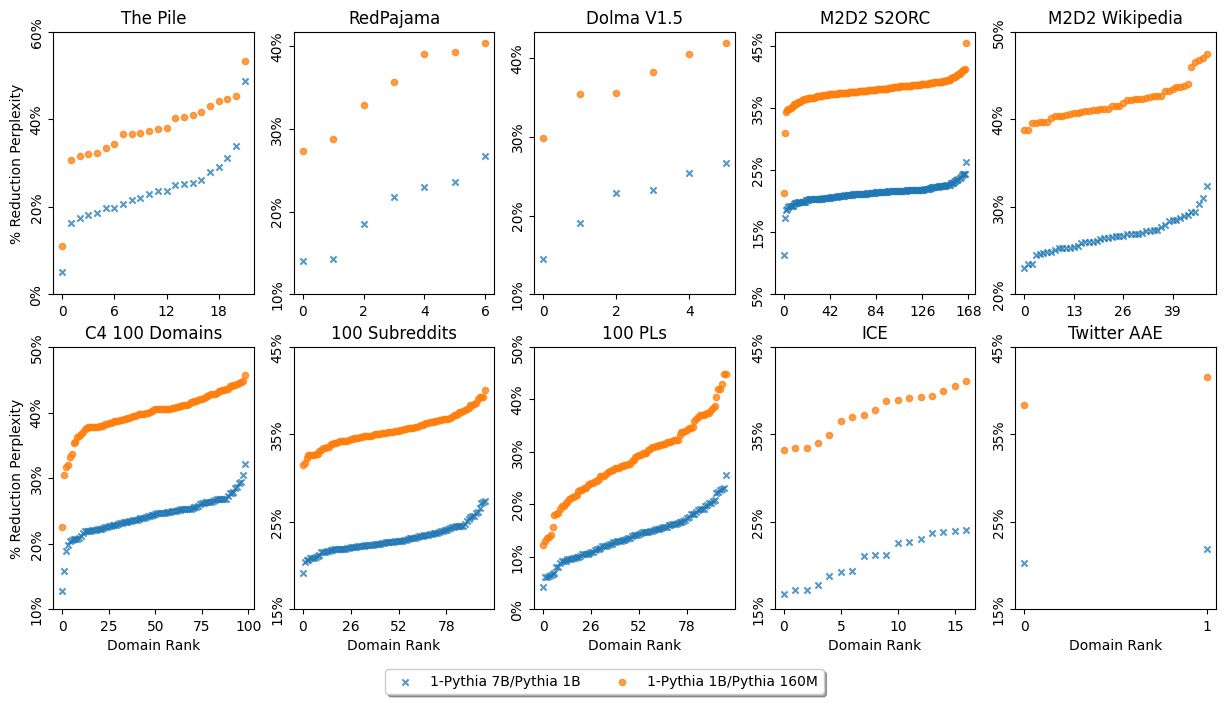

In [265]:
# comparing improvements over model sizes
import matplotlib
cols = 5
tasks = ['ppl_'+domain for domain in domain_order if ('ppl_'+domain) in (domains_with_subdomains - {'ppl_manosphere_meta_sep'})]
fig, axs = plt.subplots(len(task_to_domains) // cols, cols, figsize=(15, 7.5), gridspec_kw={'hspace': 0.2, 'wspace': 0.2})
most_improved_domains = {}
least_improved_domains = {}
for pair_idx, model_pair in enumerate([('pythia-6.9b', 'pythia-1b'), ('pythia-1b', 'pythia-160m')]):
    most_improved_domains[f"1-{name_to_display[model_pair[0]]}/{name_to_display[model_pair[1]]}"] = {}
    least_improved_domains[f"1-{name_to_display[model_pair[0]]}/{name_to_display[model_pair[1]]}"] = {}
    for j, task_name in enumerate(tasks):
        max_data = {}
        for i, model_name in enumerate(model_pair):
            model = model_name_to_path[model_name]
            task_files = get_task_subdomains_results_files(results_files_clean, metric_name, task_name)
            model_path = os.path.join(RESULTS_DIR, model)
            all_subdomains = get_metric_for_all_subdomains(model_path, task_files, metric_name)
            max_data[model_name] = all_subdomains[all_subdomains['tokens_seen'] == all_subdomains['tokens_seen'].max()].reset_index(drop=True)
        domains = list(tasts_to_domains_clean[task_name])
        max_all_subdomains = max_data[model_pair[0]]
        min_all_subdomains = max_data[model_pair[1]]
        ratio_by_subdomain = 1 - max_all_subdomains[domains] / min_all_subdomains[domains]
        ratio_by_subdomain_series = ratio_by_subdomain.iloc[0].T
        negative_reduction = ratio_by_subdomain_series[ratio_by_subdomain_series < 0.0]

        most_improved = ratio_by_subdomain_series.sort_values(ascending=False)
        most_improved_domains[f"1-{name_to_display[model_pair[0]]}/{name_to_display[model_pair[1]]}"][task_name] = {}
        most_improved_domains[f"1-{name_to_display[model_pair[0]]}/{name_to_display[model_pair[1]]}"][task_name]['domain'] = most_improved.index[0]
        most_improved_domains[f"1-{name_to_display[model_pair[0]]}/{name_to_display[model_pair[1]]}"][task_name]['reduction'] = f"{most_improved.iloc[0]:.2%}"

        least_improved_domains[f"1-{name_to_display[model_pair[0]]}/{name_to_display[model_pair[1]]}"][task_name] = {}
        least_improved_domains[f"1-{name_to_display[model_pair[0]]}/{name_to_display[model_pair[1]]}"][task_name]['domain'] = most_improved.index[-1]
        least_improved_domains[f"1-{name_to_display[model_pair[0]]}/{name_to_display[model_pair[1]]}"][task_name]['reduction'] = f"{most_improved.iloc[-1]:.2%}"
        
        if len(negative_reduction):
            print(task_name)
            print(negative_reduction)
        ratio_by_subdomain = ratio_by_subdomain.values.flatten()
        ratio_by_subdomain.sort()
        y_axis = ratio_by_subdomain
        x_axis = np.arange(len(ratio_by_subdomain))
        axs[j//cols][j%cols].scatter(x_axis, y_axis, label=(f"1-{name_to_display[model_pair[0]]}/{name_to_display[model_pair[1]]}"), s=20, alpha=0.75, marker="x" if pair_idx == 0 else "o")
        if j // cols == len(axs) - 1:
            axs[j//cols][j%cols].set_xlabel("Domain Rank")
        # axs[j//cols][j%cols].set_xlabel("Domain Rank")
        if j % cols == 0:
            axs[j//cols][j%cols].set_ylabel("% Reduction Perplexity")
        # axs[j//cols][j%cols].set_ylabel("% Reduction " +name_to_display[metric_name])
        axs[j//cols][j%cols].set_title(name_to_display[task_name])
        # x ticks as integers
        axs[j//cols][j%cols].xaxis.set_major_locator(matplotlib.ticker.MultipleLocator(len(ratio_by_subdomain)//4 + 1))
        # y ticks as percentages
        axs[j//cols][j%cols].yaxis.set_major_formatter(matplotlib.ticker.PercentFormatter(1.0))
        # print(len(ratio_by_subdomain))
        # axs[j//cols][j%cols].set_xlim(0, len(ratio_by_subdomain))

for j in range(len(tasks)):
    y_ticks = axs[j//cols][j%cols].get_yticks()[::2]
    axs[j//cols][j%cols].set_yticks(y_ticks)
    axs[j//cols][j%cols].set_yticklabels([f"{y:.0%}" for y in y_ticks], rotation='vertical', ha='right', va='center')
axs[-1][0].legend(loc='upper center', bbox_to_anchor=(2.75, -0.2),
        ncol=3, fancybox=True, shadow=True)


fig.savefig(os.path.join(FIGURE_DIR,'domains_by_reduction_model_size.pdf'), bbox_inches='tight', dpi=300)

In [33]:
most_improved_domains_df = make_multi_index_df_from_dict(most_improved_domains, ['domain', 'reduction']).T
columns = most_improved_domains_df.columns
most_improved_domains_df[columns[:len(columns)//2-1]].to_latex(os.path.join(TABLES_DIR, 'most_improved_domains_model_size_part1.tex'), escape=True)
most_improved_domains_df[columns[len(columns)//2-1:]].to_latex(os.path.join(TABLES_DIR, 'most_improved_domains_model_size_part2.tex'), escape=True)
most_improved_domains_df

ICE  \
1-Pythia 7B/Pythia 1B   domain     PHILIPPINES_W_ALL   
                        reduction             24.08%   
1-Pythia 1B/Pythia 160m domain         IRELAND_W_ALL   
                        reduction             41.05%   

                                                                  M2D2 Wikipedia  \
1-Pythia 7B/Pythia 1B   domain     Natural_and_physical_sciences__Earth_sciences   
                        reduction                                         32.45%   
1-Pythia 1B/Pythia 160m domain     Natural_and_physical_sciences__Earth_sciences   
                        reduction                                         47.51%   

                                  100 Subreddits M2D2 S2ORC  \
1-Pythia 7B/Pythia 1B   domain            42_wow     hep-ex   
                        reduction         27.41%     26.26%   
1-Pythia 1B/Pythia 160m domain       80_buildapc     hep-ex   
                        reduction         40.06%     45.54%   

                                                C4 100 Domains     100 PLs  \
1-Pythia 7B/Pythia 1B   domain     97_archives.lib.state.ma.us      35_ini   
                        reduction                       32.23%      25.57%   
1-Pythia 1B/Pythia 160m domain                 76_deadline.com  37_haskell   
                        reduction                       45.66%      44.91%   

                                  Twitter AAE          The Pile  RedPajama  \
1-Pythia 7B/Pythia 1B   domain             AA     OpenSubtitles  wikipedia   
                        reduction      21.94%            48.87%     26.73%   
1-Pythia 1B/Pythia 160m domain          white  YoutubeSubtitles  wikipedia   
                        reduction      41.54%            53.39%     40.39%   

                                  Dolma V1.5  
1-Pythia 7B/Pythia 1B   domain         books  
                        reduction     26.69%  
1-Pythia 1B/Pythia 160m domain          wiki  
                        reduction     41.92%

In [34]:
least_improved_domains_df = make_multi_index_df_from_dict(least_improved_domains, ['domain', 'reduction']).T
columns = least_improved_domains_df.columns
least_improved_domains_df[columns[:len(columns)//2-1]].to_latex(os.path.join(TABLES_DIR, 'least_improved_domains_model_size_part1.tex'), escape=True)
least_improved_domains_df[columns[len(columns)//2-1:]].to_latex(os.path.join(TABLES_DIR, 'least_improved_domains_model_size_part2.tex'), escape=True)
least_improved_domains_df

ICE  \
1-Pythia 7B/Pythia 1B   domain     JAMAICA_S_ALL   
                        reduction         16.75%   
1-Pythia 1B/Pythia 160m domain      CANADA_S_ALL   
                        reduction         33.27%   

                                                                 M2D2 Wikipedia  \
1-Pythia 7B/Pythia 1B   domain                    Health_and_fitness__Nutrition   
                        reduction                                        23.02%   
1-Pythia 1B/Pythia 160m domain     Mathematics_and_logic__Fields_of_mathematics   
                        reduction                                        38.75%   

                                  100 Subreddits M2D2 S2ORC  \
1-Pythia 7B/Pythia 1B   domain     66_depression    stat.ME   
                        reduction         19.22%     11.35%   
1-Pythia 1B/Pythia 160m domain     66_depression    stat.ME   
                        reduction         31.47%     21.32%   

                                                C4 100 Domains  \
1-Pythia 7B/Pythia 1B   domain     82_mail-archives.apache.org   
                        reduction                       12.76%   
1-Pythia 1B/Pythia 160m domain     82_mail-archives.apache.org   
                        reduction                       22.50%   

                                            100 PLs Twitter AAE  \
1-Pythia 7B/Pythia 1B   domain     17_unity3d-asset       white   
                        reduction             4.25%      20.31%   
1-Pythia 1B/Pythia 160m domain               50_edn          AA   
                        reduction            12.32%      38.33%   

                                         The Pile RedPajama     Dolma V1.5  
1-Pythia 7B/Pythia 1B   domain     DM_Mathematics    github  stack_uniform  
                        reduction           5.22%    14.02%         14.53%  
1-Pythia 1B/Pythia 160m domain     DM_Mathematics    github  stack_uniform  
                        reduction          11.02%    27.28%         29.87%

In [35]:
# # comparing improvements over model sizes
# import matplotlib
# cols = 5
# fig, axs = plt.subplots(len(task_to_domains) // cols, cols, figsize=(15, 7.5), gridspec_kw={'hspace': 0.5, 'wspace': 0.5})
# most_improved_domains = {}
# least_improved_domains = {}
# for j, task_name in enumerate(tasts_to_domains_clean.keys()):
#     max_data = {}
#     for i, model_name in enumerate(['pythia-6.9b', 'pythia-1b']):
#         model = model_name_to_path[model_name]
#         task_files = get_task_subdomains_results_files(results_files_clean, metric_name, task_name)
#         model_path = os.path.join(RESULTS_DIR, model)
#         all_subdomains = get_metric_for_all_subdomains(model_path, task_files, metric_name)
#         max_data[model_name] = all_subdomains[all_subdomains['tokens_seen'] == all_subdomains['tokens_seen'].max()].reset_index(drop=True)
#     domains = list(tasts_to_domains_clean[task_name])
#     max_all_subdomains = max_data['pythia-6.9b']
#     min_all_subdomains = max_data['pythia-1b']
#     ratio_by_subdomain = 1 - max_all_subdomains[domains] / min_all_subdomains[domains]
#     ratio_by_subdomain_series = ratio_by_subdomain.iloc[0].T
#     negative_reduction = ratio_by_subdomain_series[ratio_by_subdomain_series < 0.0]

#     most_improved = ratio_by_subdomain_series.sort_values(ascending=False)
#     most_improved_domains[task_name] = {}
#     most_improved_domains[task_name]['domain'] = most_improved.index[0]
#     most_improved_domains[task_name]['reduction'] = f"{most_improved.iloc[0]:.2%}"

#     least_improved_domains[task_name] = {}
#     least_improved_domains[task_name]['domain'] = most_improved.index[-1]
#     least_improved_domains[task_name]['reduction'] = f"{most_improved.iloc[-1]:.2%}"
    
#     if len(negative_reduction):
#         print(task_name)
#         print(negative_reduction)
#     ratio_by_subdomain = ratio_by_subdomain.values.flatten()
#     ratio_by_subdomain.sort()
#     y_axis = ratio_by_subdomain
#     x_axis = np.arange(len(ratio_by_subdomain))
#     axs[j//cols][j%cols].scatter(x_axis, y_axis, label=('1 - Pythia-7b / Pythia-1b'), s=5)
#     axs[j//cols][j%cols].set_xlabel("Domain Rank")
#     axs[j//cols][j%cols].set_ylabel("% Reduction " +name_to_display[metric_name])
#     axs[j//cols][j%cols].set_title(name_to_display[task_name])
#     # y ticks as percentages
#     axs[j//cols][j%cols].yaxis.set_major_formatter(matplotlib.ticker.PercentFormatter(1.0))
#     # print(len(ratio_by_subdomain))
#     # axs[j//cols][j%cols].set_xlim(0, len(ratio_by_subdomain))

# axs[-1][0].legend(loc='upper center', bbox_to_anchor=(3, -0.3),
#         ncol=3, fancybox=True, shadow=True)


# fig.savefig(os.path.join(FIGURE_DIR,'domains_by_reduction_model_size.pdf'), bbox_inches='tight', dpi=300)

In [36]:
# most_improved_domains_df = pd.DataFrame(most_improved_domains)
# most_improved_domains_df.rename(columns=name_to_display, inplace=True)
# columns = most_improved_domains_df.columns
# most_improved_domains_df[columns[:len(columns)//2-1]].to_latex(os.path.join(TABLES_DIR, 'most_improved_domains_model_size_part1.tex'), escape=True)
# most_improved_domains_df[columns[len(columns)//2-1:]].to_latex(os.path.join(TABLES_DIR, 'most_improved_domains_model_size_part2.tex'), escape=True)
# most_improved_domains_df

In [37]:
# least_improved_domains_df = pd.DataFrame(least_improved_domains)
# least_improved_domains_df.rename(columns=name_to_display, inplace=True)
# columns = least_improved_domains_df.columns
# least_improved_domains_df[columns[:len(columns)//2-1]].to_latex(os.path.join(TABLES_DIR, 'least_improved_domains_model_size_part1.tex'), escape=True)
# least_improved_domains_df[columns[len(columns)//2-1:]].to_latex(os.path.join(TABLES_DIR, 'least_improved_domains_model_size_part2.tex'), escape=True)
# least_improved_domains_df

## Disparities datasets

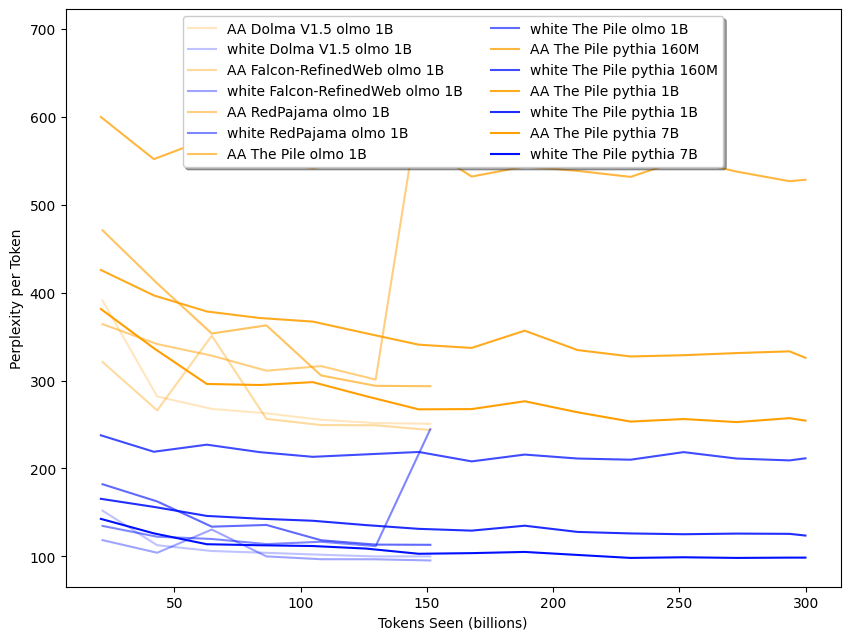

In [38]:
# show curves for each model (different color shades) over each domain (different hue) in a disparities task
# start with twitterAAE
models_all_domains = []
for i, (model_name, model) in enumerate(model_name_to_path.items()):
    model_path = os.path.join(RESULTS_DIR, model)
    models_all_domains.append(get_metric_for_all_subdomains(model_path, get_task_subdomains_results_files(results_files_clean, metric_name, 'ppl_twitterAAE_HELM_fixed'), metric_name))
models_all_domains = pd.concat(models_all_domains)

from matplotlib import colors
# domain_2_hue = {'white': 0.21303795923651603, 'AA': 0.8455261803248945}
domain_2_hue = {'white': colors.rgb_to_hsv(colors.to_rgb('blue'))[0], 'AA': colors.rgb_to_hsv(colors.to_rgb('orange'))[0]}
shades = iter(np.linspace(0.25, 1, len(model_name_to_path)))
fig, axs = plt.subplots(1, 1, figsize=(10, 7.5))
for (model, model_size, training_dataset), model_df in models_all_domains.groupby(['model', 'model_size', 'training_dataset']):
    x_axis = model_df['tokens_seen'] / 1000000000
    domains = list(set(model_df.columns) - set(shared_cols))
    # choose a random shade for this model
    shade = next(shades)
    for domain in domains:
        y_axis = model_df[domain]
        hue = domain_2_hue[domain]
        axs.plot(x_axis, y_axis, label=(domain+' '+training_dataset+' '+model+ f" {display_size(model_size)}"), color=plt.cm.hsv(hue, shade))
        # axs.plot(x_axis, y_axis, label=(domain+' '+training_dataset+' '+model+ f" {model_size/1000000000:.0f}B"))
axs.set_xlabel("Tokens Seen (billions)")
axs.set_ylabel(name_to_display[metric_name])
axs.legend(loc='upper center',
        ncol=2, fancybox=True, shadow=True)

fig.savefig(os.path.join(FIGURE_DIR,'twitterAAE_curves.pdf'), bbox_inches='tight', dpi=300)

In [39]:
top_pmi_tokens_per_domain = {}
for domain in tasts_to_domains_clean['ppl_twitterAAE_HELM_fixed']:
    domain_token_freqs = get_token_freqs(get_token_counts(['ppl_twitterAAE_HELM_fixed_token_count_avg_logits.jsonl.gz'], subdomain = 'twitterAAE_HELM_fixed__'+domain))
    domain_token_pmi = get_pmi(domain_token_freqs, all_token_freqs)

    # sort by highest to lowest pmi
    sorted_domain_token_pmi = sorted(domain_token_pmi.items(), key=lambda x: x[1], reverse=True)
    sorted_domain_token_pmi
    # unzip
    sorted_domain_token_pmi_tokens, sorted_domain_token_pmi_pmi = zip(*sorted_domain_token_pmi)

    top_pmi_tokens_per_domain[name_to_display[domain]]=sorted_domain_token_pmi_tokens[:25]

# make df
top_pmi_tokens_per_domain_df = pd.DataFrame(top_pmi_tokens_per_domain)
top_pmi_tokens_per_domain_df.to_latex(os.path.join(TABLES_DIR, 'top_pmi_tokens_per_domain_twitterAAE.tex'), escape=True)
top_pmi_tokens_per_domain_df




counting tokens in ppl_twitterAAE_HELM_fixed_token_count_avg_logits.jsonl.gz: 100%|██████████| 234017/234017 [00:00<00:00, 1730690.18it/s]
counting tokens in ppl_twitterAAE_HELM_fixed_token_count_avg_logits.jsonl.gz: 100%|██████████| 234017/234017 [00:00<00:00, 1901185.68it/s]


,AA,White
0,gether,PLL
1,jus,Austin
2,atever,nyder
3,yo,kay
4,;&,natal
5,fb,ellees
6,nig,insi
7,,becca
8,ain,ゃ
9,BGC,ielle


counting tokens in ppl_twitterAAE_HELM_fixed_token_count_avg_logits.jsonl.gz: 100%|██████████| 234017/234017 [00:00<00:00, 1858618.79it/s]
counting tokens in ppl_twitterAAE_HELM_fixed_token_count_avg_logits.jsonl.gz: 100%|██████████| 234017/234017 [00:00<00:00, 1934477.56it/s]


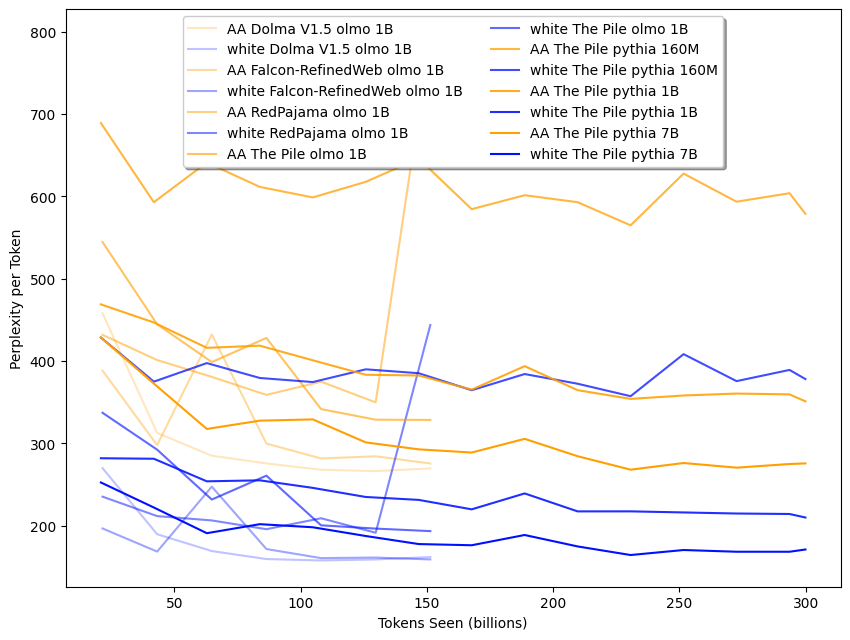

In [40]:
models_all_domains = []
for task_name in tasts_to_domains_clean['ppl_twitterAAE_HELM_fixed']:
    domain_token_freqs = get_token_freqs(get_token_counts(['ppl_twitterAAE_HELM_fixed_token_count_avg_logits.jsonl.gz'], subdomain = 'twitterAAE_HELM_fixed__'+task_name))
    domain_token_pmi = get_pmi(domain_token_freqs, all_token_freqs)

    # sort by highest to lowest pmi
    sorted_domain_token_pmi = sorted(domain_token_pmi.items(), key=lambda x: x[1], reverse=False)
    sorted_domain_token_pmi
    # unzip
    sorted_domain_token_pmi_tokens, sorted_domain_token_pmi_pmi = zip(*sorted_domain_token_pmi)
    model_all_tasks = []
    for i, (model_name, model) in enumerate(model_name_to_path.items()):
        model_path = os.path.join(RESULTS_DIR, model)
        model_all_tasks.append(get_metric_for_all_subdomains_from_vocab(model_path, ['ppl_twitterAAE_HELM_fixed'], metric_name, sorted_domain_token_pmi_tokens[-len(sorted_domain_token_pmi_tokens)//8:], task_granularity=False))
    present_shared_cols = [col for col in shared_cols if all([col in df.columns for df in model_all_tasks])]
    model_all_tasks = pd.concat(model_all_tasks)
    columns_to_drop=tasts_to_domains_clean['ppl_twitterAAE_HELM_fixed'] - set([task_name])
    model_all_tasks = model_all_tasks.drop(columns=columns_to_drop)
    models_all_domains.append(model_all_tasks)
models_all_domains = reduce(lambda left,right: pd.merge(left,right,on=list(present_shared_cols), how='outer'), models_all_domains)
models_all_domains

from matplotlib import colors
# domain_2_hue = {'white': 0.21303795923651603, 'AA': 0.8455261803248945}
domain_2_hue = {'white': colors.rgb_to_hsv(colors.to_rgb('blue'))[0], 'AA': colors.rgb_to_hsv(colors.to_rgb('orange'))[0]}
shades = iter(np.linspace(0.25, 1, len(model_name_to_path)))
fig, axs = plt.subplots(1, 1, figsize=(10, 7.5))
for (model, model_size, training_dataset), model_df in models_all_domains.groupby(['model', 'model_size', 'training_dataset']):
    x_axis = model_df['tokens_seen'] / 1000000000
    domains = list(set(model_df.columns) - set(shared_cols))
    # choose a random shade for this model
    shade = next(shades)
    for domain in domains:
        y_axis = model_df[domain]
        hue = domain_2_hue[domain]
        axs.plot(x_axis, y_axis, label=(domain+' '+training_dataset+' '+model+ f" {display_size(model_size)}"), color=plt.cm.hsv(hue, shade))
        # axs.plot(x_axis, y_axis, label=(domain+' '+training_dataset+' '+model+ f" {model_size/1000000000:.0f}B"))
axs.set_xlabel("Tokens Seen (billions)")
axs.set_ylabel(name_to_display[metric_name])
axs.legend(loc='upper center',
        ncol=2, fancybox=True, shadow=True)

fig.savefig(os.path.join(FIGURE_DIR,'pmi_twitterAAE_curves.pdf'), bbox_inches='tight', dpi=300)

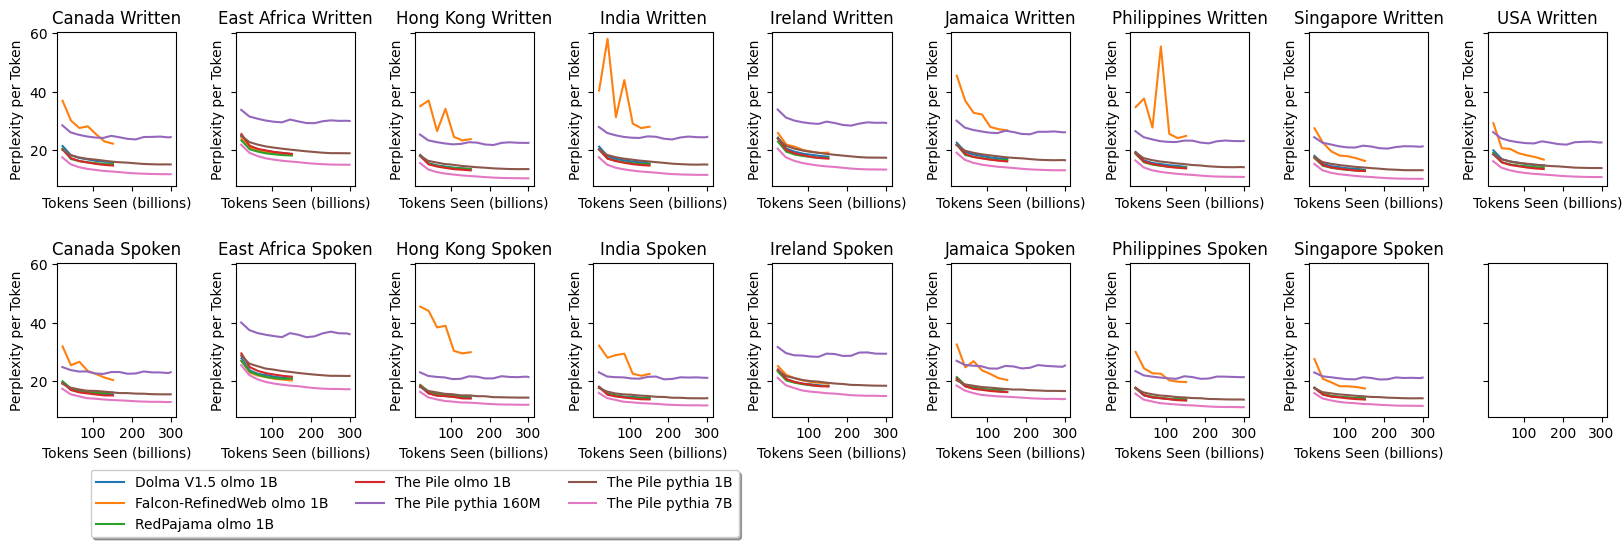

In [41]:
# start with ICE
models_all_domains = []
for i, (model_name, model) in enumerate(model_name_to_path.items()):
    model_path = os.path.join(RESULTS_DIR, model)
    models_all_domains.append(get_metric_for_all_subdomains(model_path, get_task_subdomains_results_files(results_files_clean, metric_name, 'ppl_ice_fixed'), metric_name))
models_all_domains = pd.concat(models_all_domains)

domains = list(set(models_all_domains.columns) - set(shared_cols))
domains_spoken = [domain for domain in domains if '_S_' in domain]
domains_spoken.sort()
domains_written = [domain for domain in domains if '_W_' in domain]
domains_written.sort()
domains = domains_written + domains_spoken
cols = 9
fig, axs = plt.subplots(len(domains) // cols + 1, cols, figsize=(20, 5), gridspec_kw={'hspace': 0.5, 'wspace': 0.5}, sharex=True, sharey=True)
for (model, model_size, training_dataset), model_df in models_all_domains.groupby(['model', 'model_size', 'training_dataset']):
    x_axis = model_df['tokens_seen'] / 1000000000
    for i, domain in enumerate(domains):
        y_axis = model_df[domain]
        axs[i//cols][i%cols].plot(x_axis, y_axis, label=(training_dataset+' '+model+ f" {display_size(model_size)}"))
        axs[i//cols][i%cols].set_xlabel("Tokens Seen (billions)")
        axs[i//cols][i%cols].set_ylabel(name_to_display[metric_name])
        axs[i//cols][i%cols].set_title(name_to_display[domain])
axs[-1][0].legend(loc='upper center', bbox_to_anchor=(3, -0.3),
        ncol=3, fancybox=True, shadow=True)


fig.savefig(os.path.join(FIGURE_DIR,'ICE_curves.pdf'), bbox_inches='tight', dpi=300)

In [42]:
# top_pmi_tokens_per_domain = {}
# for domain in tasts_to_domains_clean['ppl_ice_fixed']:
#     domain_token_freqs = get_token_freqs(get_token_counts(['ppl_ice_fixed_token_count_avg_logits.jsonl.gz'], subdomain = 'ice_HELM__'+domain))
#     domain_token_pmi = get_pmi(domain_token_freqs, all_token_freqs)

#     # sort by highest to lowest pmi
#     sorted_domain_token_pmi = sorted(domain_token_pmi.items(), key=lambda x: x[1], reverse=True)
#     sorted_domain_token_pmi
#     # unzip
#     sorted_domain_token_pmi_tokens, sorted_domain_token_pmi_pmi = zip(*sorted_domain_token_pmi)

#     top_pmi_tokens_per_domain[name_to_display[domain]]=sorted_domain_token_pmi_tokens[:25]

# with open(os.path.join(TOKEN_COUNTS_DIR, "ice_top_pmi_tokens_per_domain.json"), 'w') as fout:
#     json.dump(top_pmi_tokens_per_domain, fout)
with open(os.path.join(TOKEN_COUNTS_DIR, "ice_top_pmi_tokens_per_domain.json"), 'r') as fin:
    top_pmi_tokens_per_domain = json.load(fin)

# make df
top_pmi_tokens_per_domain_df = pd.DataFrame(top_pmi_tokens_per_domain)
top_pmi_tokens_per_domain_df.to_latex(os.path.join(TABLES_DIR, 'top_pmi_tokens_per_domain_ice.tex'), escape=True)
top_pmi_tokens_per_domain_df


,India Spoken,East Africa Spoken,Singapore Spoken,Ireland Written,Hong Kong Written,Canada Written,Philippines Written,Hong Kong Spoken,Singapore Written,USA Written,East Africa Written,Canada Spoken,Jamaica Written,India Written,Ireland Spoken,Philippines Spoken,Jamaica Spoken
0,ecause,yond,Petitioners,Ð,rsquo,,idopsis,unc,behavi,inical,hether,hmm,earthqu,Ibid,syll,polymers,
1,ammon,Excell,Indones,*>,HbA,ipeg,ernate,ll,clo,,sime,Mm,adoles,enthus,Aye,Atty,Jama
2,spermat,/>.,Ya,prest,HK,riched,opausal,hm,gesterone,ometimes,scious,swick,,pestic,hatic,empre,<-
3,behavi,maize,Defendants,DMSO,amyl,Qué,pes,Defendant,reef,,ederal,Sutton,Jamaica,krit,Tao,incorpor,Geoffrey
4,tablespoons,/>,dur,lace,mellitus,Canad,ORANDUM,Kong,apore,,appellants,atchewan,ometimes,progen,Belfast,Honor,",,"
5,",,",?>,Plaintiffs,Belfast,hk,nutrients,quo,Hong,Disorders,predicated,respondent,hh,progen,inition,Mm,pes,Jamaica
6,Kashmir,iban,Kok,mould,mmol,Hume,Philippine,huh,iddell,bersome,Appellant,Brunswick,Jama,hatic,Irish,Exhibit,)</
7,ammonium,oslov,counterclaim,sludge,GTT,,\n\n \n,defendant,Singapore,ligation,Juda,Bears,Carib,germination,Huh,Honorable,donkey
8,teaspoons,airo,ah,pollen,diox,travail,Ramos,Uh,459,obenz,BCG,Deg,\n\n,etch,Okay,andez,complainant
9,Punjab,amined,Respondents,Dear,hypergly,\n\n\n,Elli,Z,cloves,substantial,afore,Ya,,oxia,rendan,Lucia,Kingston


## fringe datasets


In [43]:
fringe_domains

{'ppl_4chan_meta_sep', 'ppl_gab', 'ppl_manosphere_meta_sep'}

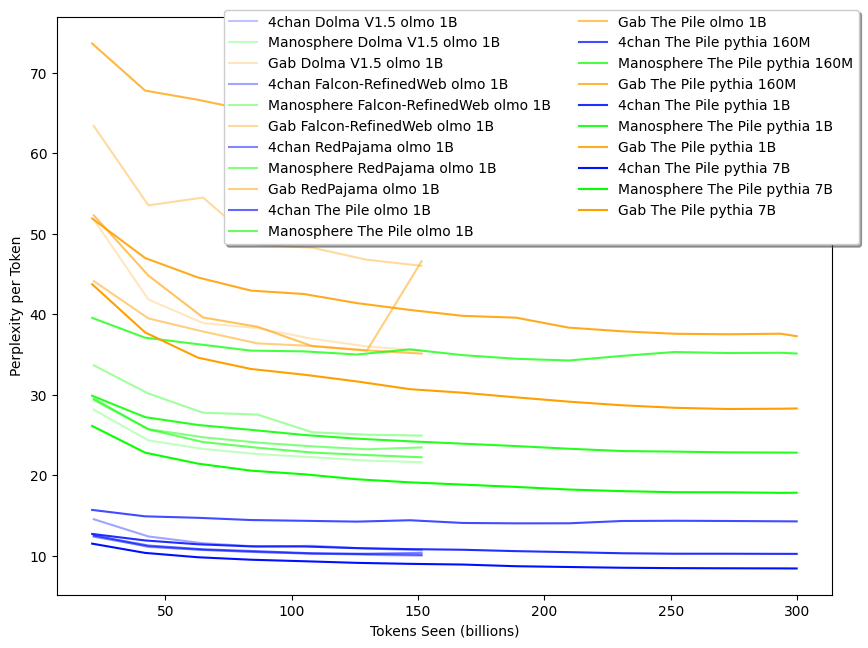

In [44]:

models_all_domains = []
for i, (model_name, model) in enumerate(model_name_to_path.items()):
    model_path = os.path.join(RESULTS_DIR, model)
    models_all_domains.append(get_metric_for_all_subdomains(model_path, [], metric_name, fringe_domains))
models_all_domains = pd.concat(models_all_domains)
models_all_domains

from matplotlib import colors
domain_2_hue = {
    'ppl_4chan_meta_sep':colors.rgb_to_hsv(colors.to_rgb('blue'))[0],
    'ppl_gab':colors.rgb_to_hsv(colors.to_rgb('orange'))[0],
    'ppl_manosphere_meta_sep':colors.rgb_to_hsv(colors.to_rgb('green'))[0]
}
shades = iter(np.linspace(0.25, 1, len(model_name_to_path)))
fig, axs = plt.subplots(1, 1, figsize=(10, 7.5))
for (model, model_size, training_dataset), model_df in models_all_domains.groupby(['model', 'model_size', 'training_dataset']):
    x_axis = model_df['tokens_seen'] / 1000000000
    domains = list(set(model_df.columns) - set(shared_cols))
    # choose a random shade for this model
    shade = next(shades)
    for domain in domains:
        y_axis = model_df[domain]
        hue = domain_2_hue[domain]
        axs.plot(x_axis, y_axis, label=(name_to_display[domain]+' '+training_dataset+' '+model+ f" {display_size(model_size)}"), color=plt.cm.hsv(hue, shade))
        # axs.plot(x_axis, y_axis, label=(domain+' '+training_dataset+' '+model+ f" {model_size/1000000000:.0f}B"))
axs.set_xlabel("Tokens Seen (billions)")
axs.set_ylabel(name_to_display[metric_name])
axs.legend(loc='upper center', bbox_to_anchor=(.625, 1.025),
        ncol=2, fancybox=True, shadow=True)

fig.savefig(os.path.join(FIGURE_DIR,'fringe_curves.pdf'), bbox_inches='tight', dpi=300)

In [45]:
top_pmi_tokens_per_domain = {}
for domain in fringe_domains:
    domain_token_freqs = get_token_freqs(get_token_counts([domain+'_token_count_avg_logits.jsonl.gz']))
    domain_token_pmi = get_pmi(domain_token_freqs, all_token_freqs)

    # sort by highest to lowest pmi
    sorted_domain_token_pmi = sorted(domain_token_pmi.items(), key=lambda x: x[1], reverse=True)
    sorted_domain_token_pmi
    # unzip
    sorted_domain_token_pmi_tokens, sorted_domain_token_pmi_pmi = zip(*sorted_domain_token_pmi)

    top_pmi_tokens_per_domain[name_to_display[domain]]=sorted_domain_token_pmi_tokens[:25]

# make df
top_pmi_tokens_per_domain_df = pd.DataFrame(top_pmi_tokens_per_domain)
top_pmi_tokens_per_domain_df.to_latex(os.path.join(TABLES_DIR, 'top_pmi_tokens_per_domain_fringe.tex'), escape=True)
top_pmi_tokens_per_domain_df




counting tokens in ppl_4chan_meta_sep_token_count_avg_logits.jsonl.gz: 100%|██████████| 171171/171171 [00:00<00:00, 1701634.01it/s]
counting tokens in ppl_manosphere_meta_sep_token_count_avg_logits.jsonl.gz: 100%|██████████| 546931/546931 [00:00<00:00, 1788816.89it/s]
counting tokens in ppl_gab_token_count_avg_logits.jsonl.gz: 100%|██████████| 216006/216006 [00:00<00:00, 1713193.23it/s]


,4chan,Manosphere,Gab
0,parison,BOOST,zitter
1,icense,sÃ,
2,Anonymous,amss,*-*
3,Tue,ortunately,pmb
4,Fri,ella,ssä
5,Thu,Wrote,frak
6,Wed,leted,ottom
7,Sun,Click,WARRANT
8,Sat,HB,Gab
9,>>,_________________,MAG


In [46]:
get_metric_for_all_subdomains_from_vocab(model_path, ['ppl_manosphere_meta_sep'], 'ppl_token', sorted_domain_token_pmi_tokens, task_granularity=True)

,ppl_manosphere_meta_sep,training_dataset,model_size,model,training_steps,tokens_seen
0,25.009958,The Pile,6444163072,pythia,10000,20971520000
1,21.884677,The Pile,6444163072,pythia,20000,41943040000
2,20.586441,The Pile,6444163072,pythia,30000,62914560000
3,19.782327,The Pile,6444163072,pythia,40000,83886080000
4,19.346425,The Pile,6444163072,pythia,50000,104857600000
5,18.766606,The Pile,6444163072,pythia,60000,125829120000
6,18.401320,The Pile,6444163072,pythia,70000,146800640000
7,18.130786,The Pile,6444163072,pythia,80000,167772160000
8,17.863023,The Pile,6444163072,pythia,90000,188743680000
9,17.565299,The Pile,6444163072,pythia,100000,209715200000


counting tokens in ppl_4chan_meta_sep_token_count_avg_logits.jsonl.gz: 100%|██████████| 171171/171171 [00:00<00:00, 1713406.94it/s]
counting tokens in ppl_manosphere_meta_sep_token_count_avg_logits.jsonl.gz: 100%|██████████| 546931/546931 [00:00<00:00, 1870125.36it/s]
counting tokens in ppl_gab_token_count_avg_logits.jsonl.gz: 100%|██████████| 216006/216006 [00:00<00:00, 1665107.22it/s]


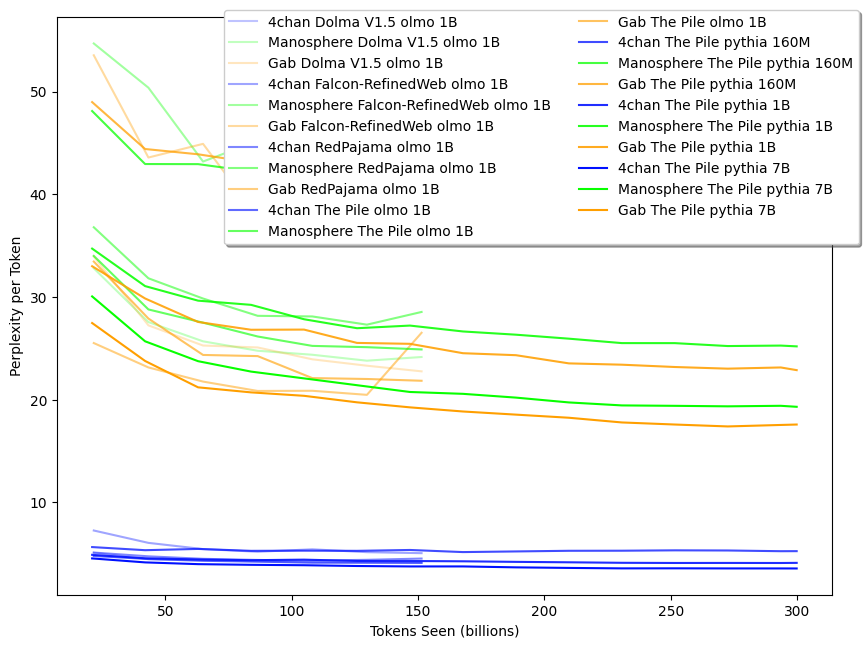

In [47]:
models_all_domains = []
for task_name in fringe_domains:
    domain_token_freqs = get_token_freqs(get_token_counts([task_name+'_token_count_avg_logits.jsonl.gz']))
    domain_token_pmi = get_pmi(domain_token_freqs, all_token_freqs)

    # sort by highest to lowest pmi
    sorted_domain_token_pmi = sorted(domain_token_pmi.items(), key=lambda x: x[1], reverse=False)
    sorted_domain_token_pmi
    # unzip
    sorted_domain_token_pmi_tokens, sorted_domain_token_pmi_pmi = zip(*sorted_domain_token_pmi)
    model_all_tasks = []
    for i, (model_name, model) in enumerate(model_name_to_path.items()):
        model_path = os.path.join(RESULTS_DIR, model)
        model_all_tasks.append(get_metric_for_all_subdomains_from_vocab(model_path, [task_name], metric_name, sorted_domain_token_pmi_tokens[-len(sorted_domain_token_pmi_tokens)//8:], task_granularity=True))
    present_shared_cols = [col for col in shared_cols if all([col in df.columns for df in model_all_tasks])]
    model_all_tasks = pd.concat(model_all_tasks)
    models_all_domains.append(model_all_tasks)
models_all_domains = reduce(lambda left,right: pd.merge(left,right,on=list(present_shared_cols), how='outer'), models_all_domains)
models_all_domains

from matplotlib import colors
domain_2_hue = {
    'ppl_4chan_meta_sep':colors.rgb_to_hsv(colors.to_rgb('blue'))[0],
    'ppl_gab':colors.rgb_to_hsv(colors.to_rgb('orange'))[0],
    'ppl_manosphere_meta_sep':colors.rgb_to_hsv(colors.to_rgb('green'))[0]
}
shades = iter(np.linspace(0.25, 1, len(model_name_to_path)))
fig, axs = plt.subplots(1, 1, figsize=(10, 7.5))
for (model, model_size, training_dataset), model_df in models_all_domains.groupby(['model', 'model_size', 'training_dataset']):
    x_axis = model_df['tokens_seen'] / 1000000000
    domains = list(set(model_df.columns) - set(shared_cols))
    # choose a random shade for this model
    shade = next(shades)
    for domain in domains:
        y_axis = model_df[domain]
        hue = domain_2_hue[domain]
        axs.plot(x_axis, y_axis, label=(name_to_display[domain]+' '+training_dataset+' '+model+ f" {display_size(model_size)}"), color=plt.cm.hsv(hue, shade))
        # axs.plot(x_axis, y_axis, label=(domain+' '+training_dataset+' '+model+ f" {model_size/1000000000:.0f}B"))
axs.set_xlabel("Tokens Seen (billions)")
axs.set_ylabel(name_to_display[metric_name])
axs.legend(loc='upper center', bbox_to_anchor=(.625, 1.025),
        ncol=2, fancybox=True, shadow=True)

fig.savefig(os.path.join(FIGURE_DIR,'pmi_fringe_curves.pdf'), bbox_inches='tight', dpi=300)

## Decontamination removal rates

In [48]:
decon_stats = [
    [name_to_macro['dolma-v1_5'], 0.00062],
    [name_to_macro['redpajama'], 1 - 900799243 / 901687943],
    [name_to_macro['pile'], 1 - 204809882 / 210607728],
    [name_to_macro['falcon-refinedweb'], 1- 912114192 / 918848690 ],
    [name_to_macro['c4_en'], 1 - 364121142 / 364156258 ],
    [name_to_macro['mc4'], 1 -  3928652800 / 3928733374],
]

decon_stats_df = pd.DataFrame(decon_stats, columns=['Dataset', 'Document Removal Rate'])
formaters = {'Document Removal Rate': lambda x: f'{x:.3%}'.replace('%', '\%')}
decon_stats_df.to_latex(os.path.join(TABLES_DIR, 'decon_removal.tex'), index=False, formatters=formaters)
decon_stats_df.style.format({'Document Removal Rate': "{:.3%}"})

,Dataset,Document Removal Rate
0,\dolma,0.062%
1,\redPajama,0.099%
2,\pile,2.753%
3,\falcon,0.733%
4,\cFour,0.010%
5,\mCFourEn,0.002%


# AS FAR AS I GOT adding multi-model support

In [49]:
# bar chart over domains (no labels) of final dolma and pythia model

# bar chart of win rate over all final models
model_path = os.path.join(RESULTS_DIR, "pythia/1b")
pythia_all_subdomains = get_metric_for_all_subdomains(model_path, results_files_clean, 'ppl_token', domains_without_subdomains_clean)

model_path = os.path.join(RESULTS_DIR, "olmo/1b/olmo-small-dolma-150B-mcli-results")
dolma_all_subdomains = get_metric_for_all_subdomains(model_path, results_files_clean, 'ppl_token', domains_without_subdomains_clean)

# concat the two dataframes
all_subdomains = pd.concat([pythia_all_subdomains, dolma_all_subdomains])

# get the max 'tokens_seen' for each model
all_subdomains = all_subdomains.sort_values(by=['tokens_seen']).groupby('model').last().reset_index()

# sort domain columns by perplexity for dolma
dolma_domains_as_rows = all_subdomains[all_subdomains['model'] == 'olmo'].drop(columns=shared_cols).T.rename(columns={0: 'metric'})
domains_by_dolma_ppl = list(dolma_domains_as_rows.sort_values(by='metric', axis=0).index)


# bar chart over domains for both models


# make 3 subplots with more space between plts
fig, axs = plt.subplots(2, 1, figsize=(15, 15), gridspec_kw={'hspace': 0.75})
# ax = domain_data_by_dolma_order.T.plot.bar(width=.8)
# in first subplot, plot the top 50 domains by dolma ppl
domain_data_by_dolma_order = all_subdomains[['model'] + domains_by_dolma_ppl[-50:]].set_index('model')
domain_data_by_dolma_order.T.plot.bar(width=.8, ax=axs[0])

domain_data_by_dolma_order = all_subdomains[['model'] + domains_by_dolma_ppl[:50]].set_index('model')
domain_data_by_dolma_order.T.plot.bar(width=.8, ax=axs[1])



AttributeError: 'NoneType' object has no attribute 'split'

(0.0, 50.0)

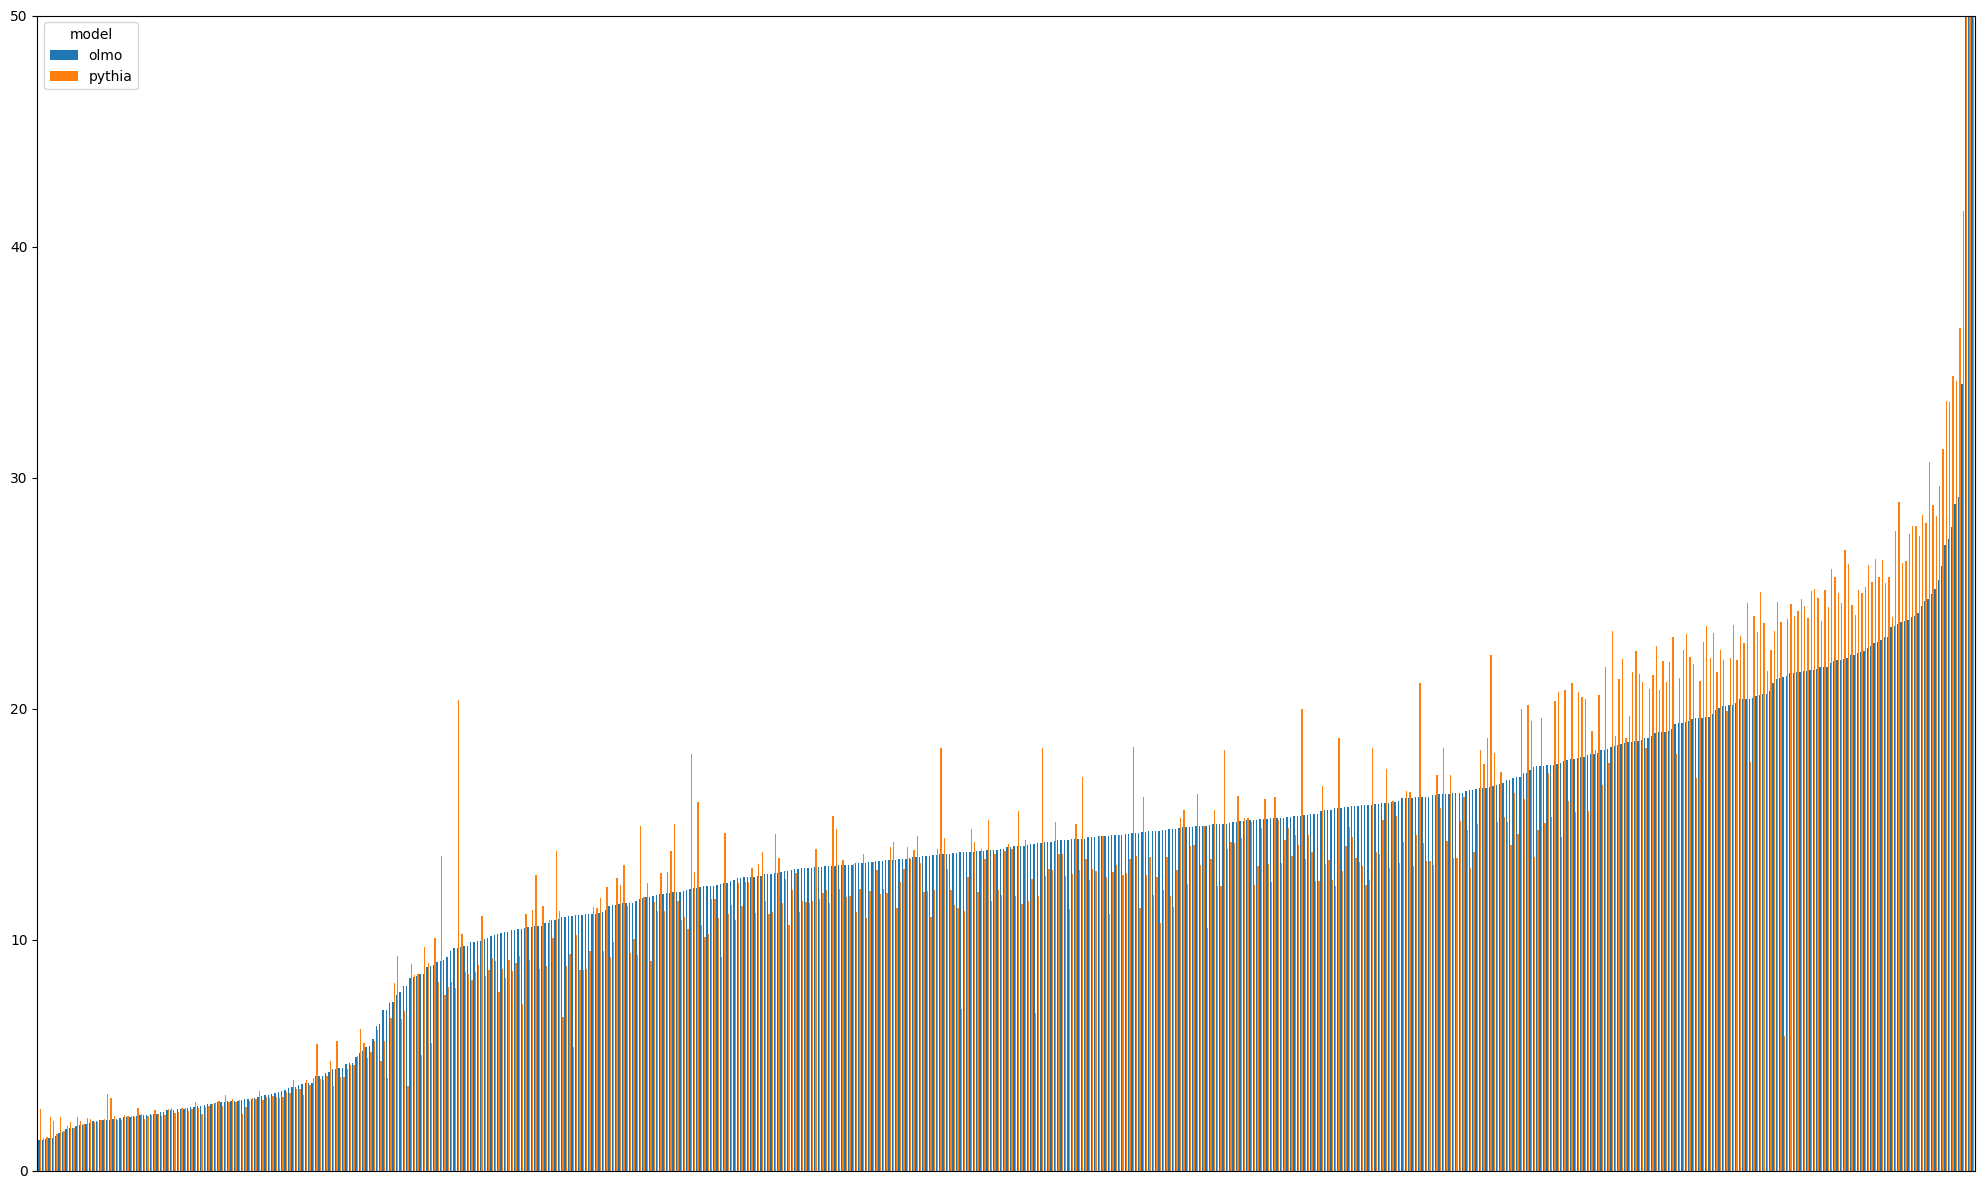

In [ ]:
domain_data_by_dolma_order = all_subdomains[['model'] + domains_by_dolma_ppl].set_index('model')
ax = domain_data_by_dolma_order.T.plot.bar(width=.8, figsize=(25, 15))
# remove the x axis labels for the last plot
ax.set_xticklabels([])
# remove the x ticks too
ax.set_xticks([])
# y limit
ax.set_ylim([0, 50])

### Win rates as curves (BETA)

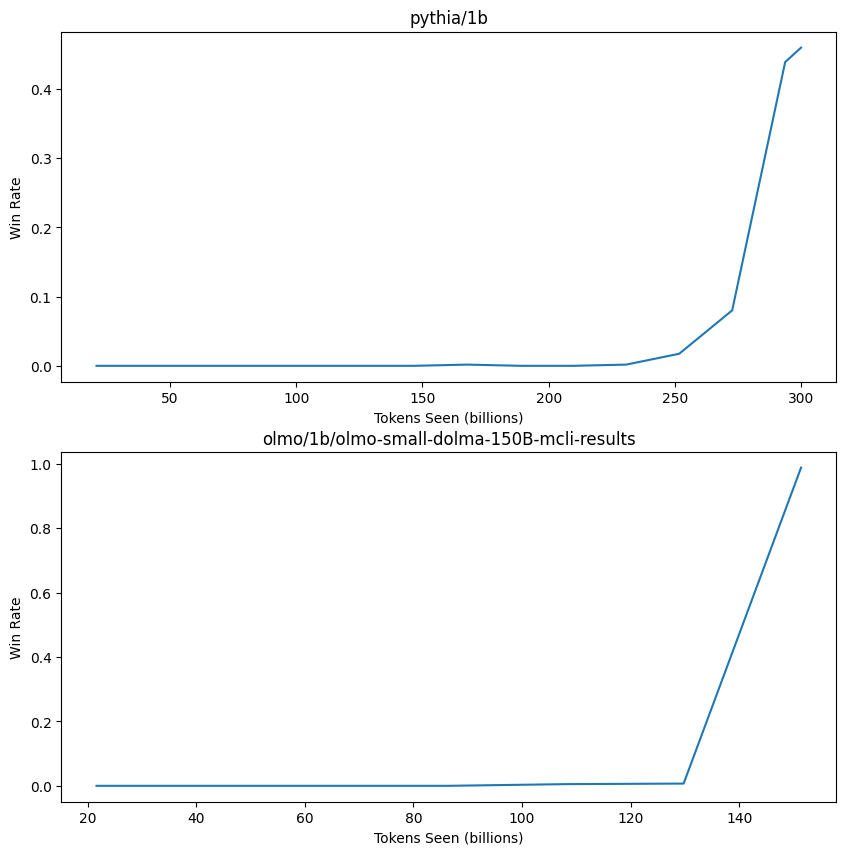

In [ ]:
# win rate over training progress for each model seperately
models = [
    "pythia/1b",
    "olmo/1b/olmo-small-dolma-150B-mcli-results"
]

import matplotlib.pyplot as plt
import numpy as np

# one subplot for each model
fig, axs = plt.subplots(len(models), figsize=(10, 10))

# line chare for each model
for i, model in enumerate(models):
    model_path = os.path.join(RESULTS_DIR, model)
    all_subdomains = get_metric_for_all_subdomains(model_path, results_files_clean, 'ppl_token', domains_without_subdomains_clean)
    win_rate = get_win_rate_over_all_subdomains(all_subdomains)
    x_axis = win_rate['tokens_seen'] / 1000000000
    y_axis = win_rate['win_rate_over_subdomains']
    axs[i].plot(x_axis, y_axis)
    axs[i].set_title(model)
    axs[i].set_xlabel("Tokens Seen (billions)")
    axs[i].set_ylabel("Win Rate")

plt.show()



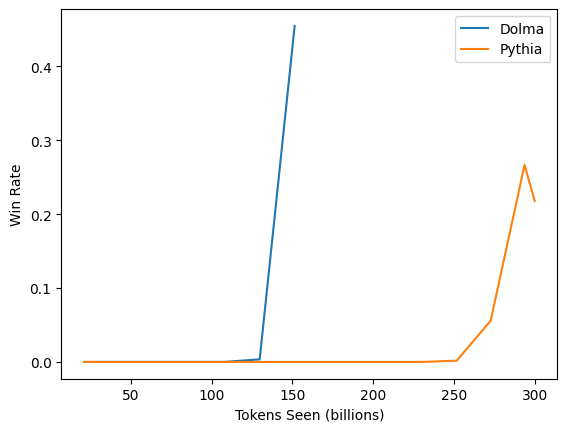

In [ ]:

model_path = os.path.join(RESULTS_DIR, "pythia/1b")
pythia_all_subdomains = get_metric_for_all_subdomains(model_path, results_files_clean, 'ppl_token', domains_without_subdomains_clean)

model_path = os.path.join(RESULTS_DIR, "olmo/1b/olmo-small-dolma-150B-mcli-results")
dolma_all_subdomains = get_metric_for_all_subdomains(model_path, results_files_clean, 'ppl_token', domains_without_subdomains_clean)

# concat the two dataframes
all_subdomains = pd.concat([pythia_all_subdomains, dolma_all_subdomains])
win_rate = get_win_rate_over_all_subdomains(all_subdomains)

# make a line chart with two lines (pythia and dolma) with the x axis being the number of tokens seen and the y axis being the perplexity
dolma_x_axis = win_rate[win_rate['model']=='olmo']['tokens_seen'] / 1000000000
dolma_y_axis = win_rate[win_rate['model']=='olmo']['win_rate_over_subdomains']

pythia_x_axis = win_rate[win_rate['model']=='pythia']['tokens_seen'] / 1000000000
pythia_y_axis = win_rate[win_rate['model']=='pythia']['win_rate_over_subdomains']

import matplotlib.pyplot as plt
import numpy as np
plt.plot(dolma_x_axis, dolma_y_axis, label="Dolma")
plt.plot(pythia_x_axis, pythia_y_axis, label="Pythia")
plt.xlabel("Tokens Seen (billions)")
plt.ylabel("Win Rate")
plt.legend()
plt.show()



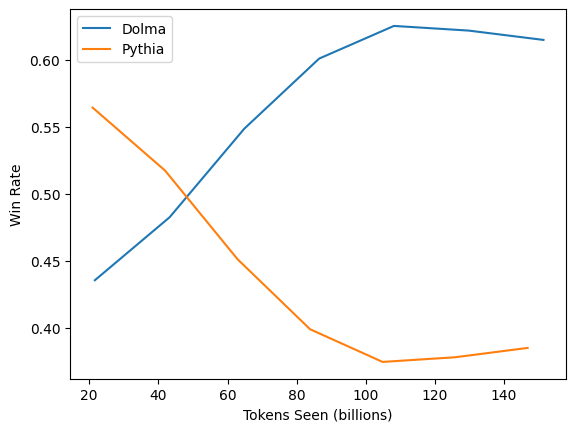

In [ ]:

model_path = os.path.join(RESULTS_DIR, "pythia/1b")
pythia_all_subdomains = get_metric_for_all_subdomains(model_path, results_files_clean, 'ppl_token', domains_without_subdomains_clean)

model_path = os.path.join(RESULTS_DIR, "olmo/1b/olmo-small-dolma-150B-mcli-results")
dolma_all_subdomains = get_metric_for_all_subdomains(model_path, results_files_clean, 'ppl_token', domains_without_subdomains_clean)

# concat the two dataframes
all_subdomains = pd.concat([pythia_all_subdomains, dolma_all_subdomains])
win_rate = get_win_rate_over_all_subdomains_by_nearest(all_subdomains, 'tokens_seen', 10000000000)

# make a line chart with two lines (pythia and dolma) with the x axis being the number of tokens seen and the y axis being the perplexity
dolma_x_axis = win_rate[win_rate['model']=='olmo']['tokens_seen'] / 1000000000
dolma_y_axis = win_rate[win_rate['model']=='olmo']['win_rate_with_nearest']

pythia_x_axis = win_rate[win_rate['model']=='pythia']['tokens_seen'] / 1000000000
pythia_y_axis = win_rate[win_rate['model']=='pythia']['win_rate_with_nearest']

import matplotlib.pyplot as plt
import numpy as np
plt.plot(dolma_x_axis, dolma_y_axis, label="Dolma")
plt.plot(pythia_x_axis, pythia_y_axis, label="Pythia")
plt.xlabel("Tokens Seen (billions)")
plt.ylabel("Win Rate")
plt.legend()
plt.show()

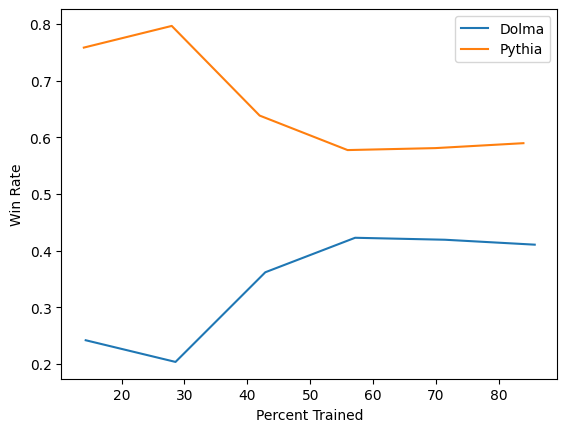

In [ ]:

model_path = os.path.join(RESULTS_DIR, "pythia/1b")
pythia_all_subdomains = get_metric_for_all_subdomains(model_path, results_files_clean, 'ppl_token', domains_without_subdomains_clean)
pythia_all_subdomains['percent_trained'] = pythia_all_subdomains['training_steps'] / pythia_all_subdomains['training_steps'].max()

model_path = os.path.join(RESULTS_DIR, "olmo/1b/olmo-small-dolma-150B-mcli-results")
dolma_all_subdomains = get_metric_for_all_subdomains(model_path, results_files_clean, 'ppl_token', domains_without_subdomains_clean)
dolma_all_subdomains['percent_trained'] = dolma_all_subdomains['training_steps'] / dolma_all_subdomains['training_steps'].max()

# concat the two dataframes
all_subdomains = pd.concat([pythia_all_subdomains, dolma_all_subdomains])
win_rate = get_win_rate_over_all_subdomains_by_nearest(all_subdomains, 'percent_trained', .2)

# make a line chart with two lines (pythia and dolma) with the x axis being the number of tokens seen and the y axis being the perplexity
dolma_x_axis = win_rate[win_rate['model']=='olmo']['percent_trained'] * 100
dolma_y_axis = win_rate[win_rate['model']=='olmo']['win_rate_with_nearest']

pythia_x_axis = win_rate[win_rate['model']=='pythia']['percent_trained'] * 100
pythia_y_axis = win_rate[win_rate['model']=='pythia']['win_rate_with_nearest']

import matplotlib.pyplot as plt
import numpy as np
plt.plot(dolma_x_axis, dolma_y_axis, label="Dolma")
plt.plot(pythia_x_axis, pythia_y_axis, label="Pythia")
plt.xlabel("Percent Trained")
plt.ylabel("Win Rate")
plt.legend()
plt.show()